In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [2]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models=[]
models.append(("Logistic Regression",LogisticRegression()))
models.append(("Decision Tree",DecisionTreeClassifier()))
models.append(("Linear Discriminant Analysis",LinearDiscriminantAnalysis()))
models.append(("Random Forest",RandomForestClassifier()))
models.append(("Support Vector Classifier",SVC()))
models.append(("K- Neirest Neighbour",KNeighborsClassifier()))
models.append(("Naive Bayes",GaussianNB()))
models.append(("XG Boost", XGBClassifier()))
models.append(("AdaBoost",AdaBoostClassifier()))
models.append(("LightGBM", LGBMClassifier()))
models.append(("CatBoost", CatBoostClassifier()))
scoring='accuracy'
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
result=[]
names=[]

In [4]:
#importer nos données
train=pd.read_excel('Memoires.xlsx')
train['date_fin_remboursement'] =pd.to_datetime(train['date_fin_remboursement'] )


In [5]:
limit=pd.Timestamp("2024-04-24 00:00:00+00:00")
train=train[train['date_fin_remboursement'] < limit]


In [6]:
train=train.drop('date_fin_remboursement',axis=1)
train=train.drop('date_dernier_remboursement',axis=1)

In [7]:
train=train[train["duree_pret_souhaitee"]>0]

In [8]:
train=train[train["age"]>0]
train.shape

(12947, 20)

In [9]:
#train=train[train['periodicite_remboursement'] != "CU"]

In [10]:
train=train.drop('nbr_echeances',axis=1)
# Dictionnaire de mappage des périodicités aux valeurs numériques
periodicite_mapping = {
    'ME': 12,  # Mensuel
    'TR': 4,   # Trimestriel
    'BI': 6,   # Bimensuel
    'SE': 2,   # Semestriel
    'CU': 0.5    # Annuelle
}

# Transformation de la colonne 'periodicite_remboursement'
train['nbr_echeances'] = train['periodicite_remboursement'].map(periodicite_mapping)
train= train.drop('periodicite_remboursement',axis=1)

#print(train)

In [11]:
variables = [
    'r', 
    'profession', 
    'age', 
    'sexe', 
    'anciennete_agence',  
    'duree_pret_souhaitee', 
    'nbr_echeances', 
    'taux_interet',
    'secteur_activite',
    'ssecteur_activite',
    'nbr_mois_cotisation',
    'a_dette_encours',
     'nbr_credits_octroyes', 
    'nbr_credits_rembourses',
       'montant_credits_accorde',
    'montant_sollicite'
]

#On a pas assez de 1 mais beaucoup de 0
train_0 = train[train['a_dette_encours'] == 0]
train_0=train_0.drop_duplicates(subset=variables,keep='last')
# Concaténer le DataFrame nettoyé avec les lignes de classe 1
train = pd.concat([train_0, train[train['a_dette_encours'] == 1]])
train.shape

(11803, 19)

In [12]:
#train = train.drop_duplicates()

In [13]:
train.shape

(11803, 19)

In [14]:
train.nbr_mois_cotisation=pd.to_numeric(train.nbr_mois_cotisation , errors='coerce' )
train=train.drop('nbr_transaction_effectuee',axis=1)
train=train.drop('duree_moyenne_remboursement',axis=1)
train=train.drop('epargne_disponible',axis=1)

In [15]:
train.shape

(11803, 16)

In [16]:
#train["duree_pret_souhaitee"]=train["duree_pret_souhaitee"].mask(train["duree_pret_souhaitee"]<=0)

In [17]:
#train["duree_pret_souhaitee"]=abs(train["duree_pret_souhaitee"])

In [18]:
train["nbr_mois_cotisation"]=abs(train["nbr_mois_cotisation"])
#train["nbr_mois_cotisation"]=train["nbr_mois_cotisation"].mask(train["nbr_mois_cotisation"]<=0)

In [19]:
#train=train[train["nbr_mois_cotisation"]>0]

In [20]:
train.describe()

,age,anciennete_agence,montant_sollicite,duree_pret_souhaitee,taux_interet,nbr_mois_cotisation,a_dette_encours,nbr_credits_octroyes,nbr_credits_rembourses,montant_credits_accorde,nbr_echeances
count,11803.000000,8044.000000,1.180300e+04,11803.000000,11803.000000,11533.000000,11803.000000,11803.000000,11803.000000,1.180300e+04,11803.000000
mean,48.372956,8.183864,9.569328e+05,14.233669,16.886476,11.434752,0.160044,5.039481,4.641193,5.063579e+06,11.948530
std,14.074277,3.025793,2.160413e+06,12.899096,6.246639,11.796371,0.366662,6.736813,6.556660,1.385320e+07,0.622475
min,6.000000,1.000000,1.000000e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.456000e+04,0.500000
25%,42.000000,6.000000,2.000000e+05,11.000000,18.000000,6.000000,0.000000,1.000000,1.000000,5.000000e+05,12.000000
50%,46.000000,9.000000,4.000000e+05,12.000000,19.000000,11.000000,0.000000,3.000000,3.000000,1.475000e+06,12.000000
75%,55.000000,11.000000,1.000000e+06,12.000000,19.000000,12.000000,0.000000,7.000000,7.000000,3.950000e+06,12.000000
max,124.000000,13.000000,5.000000e+07,85.000000,24.000000,157.000000,1.000000,100.000000,99.000000,2.620000e+08,12.000000


# Valeurs Manquantes

In [21]:
#On devrait juste emputer anciennete puisue 30 % mais c'est une variable importante dans la sélection métier
from sklearn.impute import MissingIndicator, KNNImputer,SimpleImputer
# Imputation par KNN Imputer
# KNN imputer avec 3 voisins pour plusieurs colonnes
imputer = KNNImputer(n_neighbors=3)
#train['duree_pret_souhaitee'] = imputer.fit_transform(train[['duree_pret_souhaitee']])
train[['nbr_mois_cotisation']] = imputer.fit_transform(train[['nbr_mois_cotisation']])
train[['anciennete_agence']] = imputer.fit_transform(train[['anciennete_agence']])
train.isnull().mean()

r                          0.0
profession                 0.0
age                        0.0
sexe                       0.0
anciennete_agence          0.0
montant_sollicite          0.0
duree_pret_souhaitee       0.0
taux_interet               0.0
secteur_activite           0.0
ssecteur_activite          0.0
nbr_mois_cotisation        0.0
a_dette_encours            0.0
nbr_credits_octroyes       0.0
nbr_credits_rembourses     0.0
montant_credits_accorde    0.0
nbr_echeances              0.0
dtype: float64

# Encodage

In [22]:
val_quali=['r', 'profession', 'sexe','secteur_activite','ssecteur_activite']

In [23]:
from sklearn.preprocessing import (LabelEncoder, OrdinalEncoder, OneHotEncoder,
                                    LabelBinarizer, MultiLabelBinarizer)

In [24]:
# Label encoding
label_encoder = LabelEncoder()
for bal in val_quali:
    train[bal] = label_encoder.fit_transform(train[bal])
    

In [25]:
train=pd.get_dummies(train,columns=['ssecteur_activite'])
    

# Modele final

In [26]:
train =train[train['montant_sollicite']<3000000]
train['rapport_rembourse'] = train['nbr_credits_rembourses'] /train['nbr_credits_octroyes'].replace(0, 1)
#train['a_deja_au_pret'] = train['nbr_credits_octroyes'].apply(lambda x: 0 if x == 0 else 1)
train['rapport_montant'] = ((train['montant_credits_accorde']/train['nbr_credits_octroyes'].replace(0, 1)) - train['montant_sollicite'])/(train['montant_credits_accorde']/train['nbr_credits_octroyes'].replace(0, 1))
#train=train.drop('nbr_credits_octroyes',axis=1)
train=train.drop('nbr_credits_rembourses',axis=1)
train=train.drop('sexe',axis=1)
train=train.drop('r',axis=1)
train=train.drop('secteur_activite',axis=1)
train=train.drop('profession',axis=1)
#X=X.drop('ssecteur_activite',axis=1)
train=train.drop('age',axis=1)
train=train.drop('nbr_echeances',axis=1)
train=train.drop('montant_credits_accorde',axis=1)
train=train.drop('anciennete_agence',axis=1)
#X=X.drop('duree_pret_souhaitee',axis=1)
from xgboost import XGBClassifier
from sklearn import metrics
X=train.drop('a_dette_encours',axis=1)
y=train['a_dette_encours']
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.3,random_state=1)

# Meilleurs hyperparamètres trouvés par Optuna
best_params = {
    'max_depth': 10, 'learning_rate': 0.03919290360202057, 'n_estimators': 136, 'subsample': 0.9745742103932439, 'colsample_bytree': 0.9173310957180093, 'lambda': 0.26097543152754765, 'alpha': 0.5400556413655829
}
mod3 = XGBClassifier(**best_params)
mod3.fit(train_X, train_y)
y_pred = mod3.predict(test_X)

# Afficher le rapport de classification
print(metrics.classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2714
           1       0.91      0.83      0.87       535

    accuracy                           0.96      3249
   macro avg       0.94      0.91      0.92      3249
weighted avg       0.96      0.96      0.96      3249



In [27]:
#🛑Stop

### Modele de Base

In [28]:
X=train.drop('a_dette_encours',axis=1)
y=train['a_dette_encours']

# Par Variables

In [29]:
#train =train[train['montant_sollicite']<3000000]

In [30]:
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.3,random_state=1)

In [31]:
for name,model in models:
    kfold=KFold(n_splits=10)
    #random_state=0
    cv_result=cross_val_score(model,train_X,train_y,cv=kfold,scoring=scoring)
    result.append(cv_result)
    names.append(name)
    print(model)
    print("%s %f" % (name,cv_result.mean()))
    #La définition d'un random_state n'a aucun effet puisque shuffle est False. Vous devez laisser random_state sa valeur par défaut (Aucun) ou définir shuffle=True

LogisticRegression()
Logistic Regression 0.847382
DecisionTreeClassifier()
Decision Tree 0.928373
LinearDiscriminantAnalysis()
Linear Discriminant Analysis 0.906739
RandomForestClassifier()
Random Forest 0.939982
SVC()
Support Vector Classifier 0.843689


C:\Users\HOME\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\HOME\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

KNeighborsClassifier()
K- Neirest Neighbour 0.910302
GaussianNB()
Naive Bayes 0.843689
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
XG Boost 0.941696
AdaBoostClassifier()
AdaBoost 0.938002
[LightGBM] [Info] Number of positive: 1061, number of negative: 5761
[LightGBM] [Info] Auto-choosi

52:	learn: 0.1660192	total: 578ms	remaining: 10.3s
53:	learn: 0.1648927	total: 587ms	remaining: 10.3s
54:	learn: 0.1637170	total: 597ms	remaining: 10.3s
55:	learn: 0.1624722	total: 606ms	remaining: 10.2s
56:	learn: 0.1615131	total: 613ms	remaining: 10.1s
57:	learn: 0.1608523	total: 622ms	remaining: 10.1s
58:	learn: 0.1597336	total: 629ms	remaining: 10s
59:	learn: 0.1589279	total: 636ms	remaining: 9.97s
60:	learn: 0.1581661	total: 644ms	remaining: 9.91s
61:	learn: 0.1573785	total: 651ms	remaining: 9.86s
62:	learn: 0.1565921	total: 659ms	remaining: 9.79s
63:	learn: 0.1555326	total: 667ms	remaining: 9.76s
64:	learn: 0.1547694	total: 676ms	remaining: 9.72s
65:	learn: 0.1538454	total: 683ms	remaining: 9.67s
66:	learn: 0.1530500	total: 690ms	remaining: 9.61s
67:	learn: 0.1523096	total: 698ms	remaining: 9.57s
68:	learn: 0.1515632	total: 705ms	remaining: 9.51s
69:	learn: 0.1508191	total: 712ms	remaining: 9.45s
70:	learn: 0.1500515	total: 718ms	remaining: 9.4s
71:	learn: 0.1493966	total: 725ms	

236:	learn: 0.1190113	total: 2.01s	remaining: 6.46s
237:	learn: 0.1189486	total: 2.01s	remaining: 6.45s
238:	learn: 0.1189064	total: 2.02s	remaining: 6.44s
239:	learn: 0.1188454	total: 2.05s	remaining: 6.5s
240:	learn: 0.1187537	total: 2.06s	remaining: 6.5s
241:	learn: 0.1186783	total: 2.07s	remaining: 6.49s
242:	learn: 0.1186293	total: 2.08s	remaining: 6.48s
243:	learn: 0.1185628	total: 2.09s	remaining: 6.46s
244:	learn: 0.1184492	total: 2.09s	remaining: 6.45s
245:	learn: 0.1183725	total: 2.1s	remaining: 6.44s
246:	learn: 0.1183256	total: 2.11s	remaining: 6.43s
247:	learn: 0.1181325	total: 2.12s	remaining: 6.42s
248:	learn: 0.1180852	total: 2.12s	remaining: 6.4s
249:	learn: 0.1180355	total: 2.13s	remaining: 6.39s
250:	learn: 0.1179617	total: 2.14s	remaining: 6.37s
251:	learn: 0.1179188	total: 2.14s	remaining: 6.36s
252:	learn: 0.1178065	total: 2.15s	remaining: 6.34s
253:	learn: 0.1177612	total: 2.15s	remaining: 6.33s
254:	learn: 0.1176993	total: 2.16s	remaining: 6.32s
255:	learn: 0.11

401:	learn: 0.1091055	total: 3.22s	remaining: 4.79s
402:	learn: 0.1090245	total: 3.23s	remaining: 4.79s
403:	learn: 0.1089341	total: 3.24s	remaining: 4.78s
404:	learn: 0.1088786	total: 3.25s	remaining: 4.77s
405:	learn: 0.1088351	total: 3.25s	remaining: 4.76s
406:	learn: 0.1087118	total: 3.26s	remaining: 4.75s
407:	learn: 0.1086623	total: 3.27s	remaining: 4.74s
408:	learn: 0.1085820	total: 3.27s	remaining: 4.73s
409:	learn: 0.1085568	total: 3.28s	remaining: 4.72s
410:	learn: 0.1085121	total: 3.29s	remaining: 4.71s
411:	learn: 0.1084863	total: 3.29s	remaining: 4.7s
412:	learn: 0.1084108	total: 3.3s	remaining: 4.69s
413:	learn: 0.1083729	total: 3.31s	remaining: 4.68s
414:	learn: 0.1083268	total: 3.31s	remaining: 4.67s
415:	learn: 0.1082831	total: 3.32s	remaining: 4.66s
416:	learn: 0.1082704	total: 3.32s	remaining: 4.65s
417:	learn: 0.1082447	total: 3.33s	remaining: 4.64s
418:	learn: 0.1081592	total: 3.34s	remaining: 4.63s
419:	learn: 0.1081362	total: 3.34s	remaining: 4.62s
420:	learn: 0.

586:	learn: 0.1013734	total: 4.45s	remaining: 3.13s
587:	learn: 0.1013647	total: 4.46s	remaining: 3.13s
588:	learn: 0.1013374	total: 4.47s	remaining: 3.12s
589:	learn: 0.1013345	total: 4.47s	remaining: 3.11s
590:	learn: 0.1013120	total: 4.48s	remaining: 3.1s
591:	learn: 0.1012902	total: 4.49s	remaining: 3.09s
592:	learn: 0.1012519	total: 4.5s	remaining: 3.08s
593:	learn: 0.1012443	total: 4.5s	remaining: 3.08s
594:	learn: 0.1012085	total: 4.51s	remaining: 3.07s
595:	learn: 0.1011670	total: 4.51s	remaining: 3.06s
596:	learn: 0.1011397	total: 4.52s	remaining: 3.05s
597:	learn: 0.1010878	total: 4.53s	remaining: 3.04s
598:	learn: 0.1010515	total: 4.54s	remaining: 3.04s
599:	learn: 0.1010111	total: 4.54s	remaining: 3.03s
600:	learn: 0.1009661	total: 4.55s	remaining: 3.02s
601:	learn: 0.1009287	total: 4.55s	remaining: 3.01s
602:	learn: 0.1008892	total: 4.56s	remaining: 3s
603:	learn: 0.1008770	total: 4.57s	remaining: 2.99s
604:	learn: 0.1008360	total: 4.57s	remaining: 2.99s
605:	learn: 0.1007

770:	learn: 0.0954388	total: 5.66s	remaining: 1.68s
771:	learn: 0.0954256	total: 5.67s	remaining: 1.68s
772:	learn: 0.0953989	total: 5.68s	remaining: 1.67s
773:	learn: 0.0953722	total: 5.69s	remaining: 1.66s
774:	learn: 0.0953508	total: 5.69s	remaining: 1.65s
775:	learn: 0.0953250	total: 5.7s	remaining: 1.65s
776:	learn: 0.0953069	total: 5.71s	remaining: 1.64s
777:	learn: 0.0952501	total: 5.71s	remaining: 1.63s
778:	learn: 0.0952036	total: 5.72s	remaining: 1.62s
779:	learn: 0.0951906	total: 5.72s	remaining: 1.61s
780:	learn: 0.0951691	total: 5.73s	remaining: 1.61s
781:	learn: 0.0951031	total: 5.74s	remaining: 1.6s
782:	learn: 0.0950601	total: 5.75s	remaining: 1.59s
783:	learn: 0.0950058	total: 5.75s	remaining: 1.58s
784:	learn: 0.0949889	total: 5.76s	remaining: 1.58s
785:	learn: 0.0949775	total: 5.76s	remaining: 1.57s
786:	learn: 0.0949613	total: 5.77s	remaining: 1.56s
787:	learn: 0.0949543	total: 5.78s	remaining: 1.55s
788:	learn: 0.0949352	total: 5.78s	remaining: 1.55s
789:	learn: 0.

950:	learn: 0.0901421	total: 6.87s	remaining: 354ms
951:	learn: 0.0901411	total: 6.88s	remaining: 347ms
952:	learn: 0.0901104	total: 6.89s	remaining: 340ms
953:	learn: 0.0900918	total: 6.89s	remaining: 332ms
954:	learn: 0.0900908	total: 6.9s	remaining: 325ms
955:	learn: 0.0900826	total: 6.91s	remaining: 318ms
956:	learn: 0.0900549	total: 6.91s	remaining: 311ms
957:	learn: 0.0900337	total: 6.92s	remaining: 303ms
958:	learn: 0.0899879	total: 6.93s	remaining: 296ms
959:	learn: 0.0899527	total: 6.93s	remaining: 289ms
960:	learn: 0.0899446	total: 6.94s	remaining: 282ms
961:	learn: 0.0899366	total: 6.95s	remaining: 274ms
962:	learn: 0.0898976	total: 6.95s	remaining: 267ms
963:	learn: 0.0898584	total: 6.96s	remaining: 260ms
964:	learn: 0.0898347	total: 6.97s	remaining: 253ms
965:	learn: 0.0897780	total: 6.97s	remaining: 245ms
966:	learn: 0.0897621	total: 6.98s	remaining: 238ms
967:	learn: 0.0896819	total: 6.99s	remaining: 231ms
968:	learn: 0.0896731	total: 6.99s	remaining: 224ms
969:	learn: 0

117:	learn: 0.1323408	total: 788ms	remaining: 5.89s
118:	learn: 0.1321181	total: 795ms	remaining: 5.89s
119:	learn: 0.1319238	total: 803ms	remaining: 5.88s
120:	learn: 0.1317182	total: 810ms	remaining: 5.88s
121:	learn: 0.1315389	total: 817ms	remaining: 5.88s
122:	learn: 0.1312780	total: 823ms	remaining: 5.87s
123:	learn: 0.1310552	total: 830ms	remaining: 5.87s
124:	learn: 0.1308241	total: 837ms	remaining: 5.86s
125:	learn: 0.1307007	total: 843ms	remaining: 5.85s
126:	learn: 0.1303297	total: 850ms	remaining: 5.84s
127:	learn: 0.1302236	total: 856ms	remaining: 5.83s
128:	learn: 0.1301191	total: 863ms	remaining: 5.83s
129:	learn: 0.1300002	total: 870ms	remaining: 5.82s
130:	learn: 0.1298852	total: 876ms	remaining: 5.81s
131:	learn: 0.1297522	total: 884ms	remaining: 5.81s
132:	learn: 0.1296045	total: 890ms	remaining: 5.8s
133:	learn: 0.1294177	total: 897ms	remaining: 5.8s
134:	learn: 0.1292118	total: 904ms	remaining: 5.79s
135:	learn: 0.1291015	total: 912ms	remaining: 5.79s
136:	learn: 0.

296:	learn: 0.1137101	total: 1.98s	remaining: 4.69s
297:	learn: 0.1136833	total: 1.99s	remaining: 4.68s
298:	learn: 0.1136502	total: 2s	remaining: 4.68s
299:	learn: 0.1136384	total: 2s	remaining: 4.67s
300:	learn: 0.1136140	total: 2.01s	remaining: 4.67s
301:	learn: 0.1134493	total: 2.02s	remaining: 4.66s
302:	learn: 0.1133921	total: 2.02s	remaining: 4.65s
303:	learn: 0.1132678	total: 2.03s	remaining: 4.64s
304:	learn: 0.1132387	total: 2.04s	remaining: 4.64s
305:	learn: 0.1131483	total: 2.04s	remaining: 4.63s
306:	learn: 0.1130969	total: 2.05s	remaining: 4.63s
307:	learn: 0.1129458	total: 2.06s	remaining: 4.62s
308:	learn: 0.1129000	total: 2.06s	remaining: 4.61s
309:	learn: 0.1128514	total: 2.07s	remaining: 4.61s
310:	learn: 0.1128006	total: 2.08s	remaining: 4.6s
311:	learn: 0.1127402	total: 2.08s	remaining: 4.59s
312:	learn: 0.1126960	total: 2.09s	remaining: 4.59s
313:	learn: 0.1126059	total: 2.1s	remaining: 4.58s
314:	learn: 0.1125562	total: 2.1s	remaining: 4.57s
315:	learn: 0.1124420

474:	learn: 0.1035670	total: 3.2s	remaining: 3.54s
475:	learn: 0.1034821	total: 3.21s	remaining: 3.53s
476:	learn: 0.1034005	total: 3.21s	remaining: 3.52s
477:	learn: 0.1033528	total: 3.22s	remaining: 3.52s
478:	learn: 0.1032750	total: 3.23s	remaining: 3.51s
479:	learn: 0.1032346	total: 3.24s	remaining: 3.51s
480:	learn: 0.1032150	total: 3.24s	remaining: 3.5s
481:	learn: 0.1031633	total: 3.25s	remaining: 3.49s
482:	learn: 0.1031227	total: 3.26s	remaining: 3.48s
483:	learn: 0.1030551	total: 3.26s	remaining: 3.48s
484:	learn: 0.1029803	total: 3.27s	remaining: 3.47s
485:	learn: 0.1029340	total: 3.28s	remaining: 3.46s
486:	learn: 0.1028901	total: 3.28s	remaining: 3.46s
487:	learn: 0.1028748	total: 3.29s	remaining: 3.45s
488:	learn: 0.1028356	total: 3.3s	remaining: 3.44s
489:	learn: 0.1027918	total: 3.3s	remaining: 3.44s
490:	learn: 0.1027601	total: 3.31s	remaining: 3.43s
491:	learn: 0.1027217	total: 3.31s	remaining: 3.42s
492:	learn: 0.1026854	total: 3.32s	remaining: 3.42s
493:	learn: 0.10

644:	learn: 0.0969570	total: 4.41s	remaining: 2.43s
645:	learn: 0.0969258	total: 4.42s	remaining: 2.42s
646:	learn: 0.0968917	total: 4.43s	remaining: 2.42s
647:	learn: 0.0968804	total: 4.44s	remaining: 2.41s
648:	learn: 0.0968524	total: 4.44s	remaining: 2.4s
649:	learn: 0.0968134	total: 4.45s	remaining: 2.4s
650:	learn: 0.0967760	total: 4.46s	remaining: 2.39s
651:	learn: 0.0967315	total: 4.46s	remaining: 2.38s
652:	learn: 0.0966916	total: 4.47s	remaining: 2.38s
653:	learn: 0.0966760	total: 4.48s	remaining: 2.37s
654:	learn: 0.0966455	total: 4.49s	remaining: 2.36s
655:	learn: 0.0966210	total: 4.49s	remaining: 2.36s
656:	learn: 0.0965624	total: 4.5s	remaining: 2.35s
657:	learn: 0.0965309	total: 4.51s	remaining: 2.34s
658:	learn: 0.0965195	total: 4.52s	remaining: 2.34s
659:	learn: 0.0964856	total: 4.52s	remaining: 2.33s
660:	learn: 0.0964694	total: 4.53s	remaining: 2.32s
661:	learn: 0.0964170	total: 4.54s	remaining: 2.32s
662:	learn: 0.0964046	total: 4.55s	remaining: 2.31s
663:	learn: 0.0

827:	learn: 0.0910994	total: 5.84s	remaining: 1.21s
828:	learn: 0.0910585	total: 5.85s	remaining: 1.21s
829:	learn: 0.0910147	total: 5.86s	remaining: 1.2s
830:	learn: 0.0909959	total: 5.87s	remaining: 1.19s
831:	learn: 0.0909815	total: 5.88s	remaining: 1.19s
832:	learn: 0.0909350	total: 5.88s	remaining: 1.18s
833:	learn: 0.0908960	total: 5.89s	remaining: 1.17s
834:	learn: 0.0908346	total: 5.9s	remaining: 1.17s
835:	learn: 0.0907973	total: 5.91s	remaining: 1.16s
836:	learn: 0.0907661	total: 5.92s	remaining: 1.15s
837:	learn: 0.0907619	total: 5.92s	remaining: 1.15s
838:	learn: 0.0907128	total: 5.93s	remaining: 1.14s
839:	learn: 0.0907042	total: 5.94s	remaining: 1.13s
840:	learn: 0.0906908	total: 5.95s	remaining: 1.13s
841:	learn: 0.0906743	total: 5.96s	remaining: 1.12s
842:	learn: 0.0906226	total: 5.97s	remaining: 1.11s
843:	learn: 0.0905762	total: 5.98s	remaining: 1.1s
844:	learn: 0.0905362	total: 5.99s	remaining: 1.1s
845:	learn: 0.0905028	total: 5.99s	remaining: 1.09s
846:	learn: 0.09

Learning rate set to 0.023391
0:	learn: 0.6514273	total: 7.96ms	remaining: 7.95s
1:	learn: 0.6174162	total: 15.8ms	remaining: 7.87s
2:	learn: 0.5812923	total: 23ms	remaining: 7.64s
3:	learn: 0.5456541	total: 30.8ms	remaining: 7.67s
4:	learn: 0.5128347	total: 38.3ms	remaining: 7.62s
5:	learn: 0.4848413	total: 46ms	remaining: 7.62s
6:	learn: 0.4583347	total: 54ms	remaining: 7.66s
7:	learn: 0.4351779	total: 61.1ms	remaining: 7.58s
8:	learn: 0.4144750	total: 68.8ms	remaining: 7.57s
9:	learn: 0.3955057	total: 76.2ms	remaining: 7.55s
10:	learn: 0.3800750	total: 84.2ms	remaining: 7.57s
11:	learn: 0.3618591	total: 91ms	remaining: 7.49s
12:	learn: 0.3473958	total: 98.7ms	remaining: 7.5s
13:	learn: 0.3370477	total: 106ms	remaining: 7.47s
14:	learn: 0.3252331	total: 114ms	remaining: 7.47s
15:	learn: 0.3132595	total: 121ms	remaining: 7.43s
16:	learn: 0.3035882	total: 129ms	remaining: 7.44s
17:	learn: 0.2940999	total: 136ms	remaining: 7.44s
18:	learn: 0.2857108	total: 147ms	remaining: 7.57s
19:	lea

179:	learn: 0.1228811	total: 1.45s	remaining: 6.61s
180:	learn: 0.1227876	total: 1.46s	remaining: 6.61s
181:	learn: 0.1226390	total: 1.47s	remaining: 6.61s
182:	learn: 0.1225024	total: 1.48s	remaining: 6.61s
183:	learn: 0.1224330	total: 1.49s	remaining: 6.59s
184:	learn: 0.1224045	total: 1.49s	remaining: 6.58s
185:	learn: 0.1223113	total: 1.5s	remaining: 6.58s
186:	learn: 0.1221591	total: 1.51s	remaining: 6.58s
187:	learn: 0.1219659	total: 1.52s	remaining: 6.57s
188:	learn: 0.1218487	total: 1.53s	remaining: 6.56s
189:	learn: 0.1216868	total: 1.54s	remaining: 6.55s
190:	learn: 0.1215894	total: 1.54s	remaining: 6.54s
191:	learn: 0.1215018	total: 1.55s	remaining: 6.52s
192:	learn: 0.1214059	total: 1.56s	remaining: 6.51s
193:	learn: 0.1213083	total: 1.56s	remaining: 6.5s
194:	learn: 0.1211802	total: 1.57s	remaining: 6.5s
195:	learn: 0.1210744	total: 1.58s	remaining: 6.48s
196:	learn: 0.1209323	total: 1.59s	remaining: 6.47s
197:	learn: 0.1207576	total: 1.59s	remaining: 6.46s
198:	learn: 0.1

354:	learn: 0.1097552	total: 2.86s	remaining: 5.2s
355:	learn: 0.1097111	total: 2.87s	remaining: 5.19s
356:	learn: 0.1097101	total: 2.88s	remaining: 5.18s
357:	learn: 0.1096895	total: 2.88s	remaining: 5.17s
358:	learn: 0.1095759	total: 2.89s	remaining: 5.17s
359:	learn: 0.1094967	total: 2.9s	remaining: 5.16s
360:	learn: 0.1094529	total: 2.91s	remaining: 5.15s
361:	learn: 0.1094393	total: 2.92s	remaining: 5.14s
362:	learn: 0.1093938	total: 2.92s	remaining: 5.13s
363:	learn: 0.1092710	total: 2.93s	remaining: 5.12s
364:	learn: 0.1092040	total: 2.94s	remaining: 5.11s
365:	learn: 0.1091194	total: 2.95s	remaining: 5.1s
366:	learn: 0.1090534	total: 2.95s	remaining: 5.1s
367:	learn: 0.1089835	total: 2.96s	remaining: 5.09s
368:	learn: 0.1088968	total: 2.97s	remaining: 5.08s
369:	learn: 0.1088456	total: 2.98s	remaining: 5.07s
370:	learn: 0.1088146	total: 2.98s	remaining: 5.06s
371:	learn: 0.1087689	total: 2.99s	remaining: 5.05s
372:	learn: 0.1087134	total: 3s	remaining: 5.04s
373:	learn: 0.10857

532:	learn: 0.1006021	total: 4.29s	remaining: 3.76s
533:	learn: 0.1005990	total: 4.3s	remaining: 3.75s
534:	learn: 0.1005625	total: 4.3s	remaining: 3.74s
535:	learn: 0.1005488	total: 4.31s	remaining: 3.73s
536:	learn: 0.1005438	total: 4.32s	remaining: 3.73s
537:	learn: 0.1005426	total: 4.33s	remaining: 3.71s
538:	learn: 0.1005213	total: 4.33s	remaining: 3.71s
539:	learn: 0.1004726	total: 4.34s	remaining: 3.7s
540:	learn: 0.1004324	total: 4.35s	remaining: 3.69s
541:	learn: 0.1004103	total: 4.36s	remaining: 3.68s
542:	learn: 0.1003976	total: 4.36s	remaining: 3.67s
543:	learn: 0.1003426	total: 4.37s	remaining: 3.66s
544:	learn: 0.1003094	total: 4.38s	remaining: 3.65s
545:	learn: 0.1002963	total: 4.38s	remaining: 3.65s
546:	learn: 0.1002926	total: 4.39s	remaining: 3.64s
547:	learn: 0.1002898	total: 4.4s	remaining: 3.63s
548:	learn: 0.1002091	total: 4.41s	remaining: 3.62s
549:	learn: 0.1001946	total: 4.41s	remaining: 3.61s
550:	learn: 0.1001705	total: 4.42s	remaining: 3.6s
551:	learn: 0.100

698:	learn: 0.0950485	total: 5.5s	remaining: 2.37s
699:	learn: 0.0950063	total: 5.5s	remaining: 2.36s
700:	learn: 0.0949730	total: 5.51s	remaining: 2.35s
701:	learn: 0.0949414	total: 5.52s	remaining: 2.34s
702:	learn: 0.0949355	total: 5.53s	remaining: 2.33s
703:	learn: 0.0948727	total: 5.53s	remaining: 2.33s
704:	learn: 0.0948719	total: 5.54s	remaining: 2.32s
705:	learn: 0.0948715	total: 5.54s	remaining: 2.31s
706:	learn: 0.0948063	total: 5.55s	remaining: 2.3s
707:	learn: 0.0947975	total: 5.56s	remaining: 2.29s
708:	learn: 0.0947661	total: 5.56s	remaining: 2.28s
709:	learn: 0.0947300	total: 5.57s	remaining: 2.27s
710:	learn: 0.0946942	total: 5.58s	remaining: 2.27s
711:	learn: 0.0946612	total: 5.58s	remaining: 2.26s
712:	learn: 0.0946362	total: 5.59s	remaining: 2.25s
713:	learn: 0.0946322	total: 5.6s	remaining: 2.24s
714:	learn: 0.0946017	total: 5.6s	remaining: 2.23s
715:	learn: 0.0945796	total: 5.61s	remaining: 2.23s
716:	learn: 0.0944963	total: 5.62s	remaining: 2.22s
717:	learn: 0.094

880:	learn: 0.0896742	total: 6.7s	remaining: 906ms
881:	learn: 0.0896517	total: 6.71s	remaining: 898ms
882:	learn: 0.0895975	total: 6.72s	remaining: 890ms
883:	learn: 0.0895339	total: 6.72s	remaining: 883ms
884:	learn: 0.0894915	total: 6.73s	remaining: 875ms
885:	learn: 0.0894500	total: 6.74s	remaining: 867ms
886:	learn: 0.0894398	total: 6.74s	remaining: 859ms
887:	learn: 0.0894198	total: 6.75s	remaining: 852ms
888:	learn: 0.0893945	total: 6.76s	remaining: 844ms
889:	learn: 0.0893520	total: 6.76s	remaining: 836ms
890:	learn: 0.0893354	total: 6.77s	remaining: 828ms
891:	learn: 0.0893351	total: 6.78s	remaining: 821ms
892:	learn: 0.0893015	total: 6.78s	remaining: 813ms
893:	learn: 0.0892971	total: 6.79s	remaining: 805ms
894:	learn: 0.0892706	total: 6.8s	remaining: 797ms
895:	learn: 0.0892609	total: 6.8s	remaining: 790ms
896:	learn: 0.0892238	total: 6.81s	remaining: 782ms
897:	learn: 0.0891752	total: 6.82s	remaining: 774ms
898:	learn: 0.0891672	total: 6.82s	remaining: 767ms
899:	learn: 0.0

60:	learn: 0.1585222	total: 405ms	remaining: 6.23s
61:	learn: 0.1576647	total: 412ms	remaining: 6.23s
62:	learn: 0.1567862	total: 419ms	remaining: 6.22s
63:	learn: 0.1559335	total: 426ms	remaining: 6.22s
64:	learn: 0.1550910	total: 453ms	remaining: 6.51s
65:	learn: 0.1543112	total: 460ms	remaining: 6.5s
66:	learn: 0.1534564	total: 466ms	remaining: 6.49s
67:	learn: 0.1528666	total: 473ms	remaining: 6.49s
68:	learn: 0.1520293	total: 480ms	remaining: 6.47s
69:	learn: 0.1513689	total: 486ms	remaining: 6.46s
70:	learn: 0.1505992	total: 493ms	remaining: 6.45s
71:	learn: 0.1498889	total: 499ms	remaining: 6.43s
72:	learn: 0.1494545	total: 506ms	remaining: 6.42s
73:	learn: 0.1488723	total: 512ms	remaining: 6.41s
74:	learn: 0.1483161	total: 519ms	remaining: 6.39s
75:	learn: 0.1478048	total: 525ms	remaining: 6.38s
76:	learn: 0.1473575	total: 532ms	remaining: 6.38s
77:	learn: 0.1469363	total: 538ms	remaining: 6.36s
78:	learn: 0.1465146	total: 545ms	remaining: 6.35s
79:	learn: 0.1460910	total: 551m

240:	learn: 0.1180688	total: 1.61s	remaining: 5.08s
241:	learn: 0.1179615	total: 1.62s	remaining: 5.08s
242:	learn: 0.1178970	total: 1.63s	remaining: 5.07s
243:	learn: 0.1178242	total: 1.64s	remaining: 5.07s
244:	learn: 0.1177688	total: 1.64s	remaining: 5.07s
245:	learn: 0.1177303	total: 1.65s	remaining: 5.06s
246:	learn: 0.1176643	total: 1.66s	remaining: 5.05s
247:	learn: 0.1175803	total: 1.66s	remaining: 5.04s
248:	learn: 0.1174804	total: 1.67s	remaining: 5.04s
249:	learn: 0.1174185	total: 1.68s	remaining: 5.03s
250:	learn: 0.1173656	total: 1.68s	remaining: 5.02s
251:	learn: 0.1173103	total: 1.69s	remaining: 5.02s
252:	learn: 0.1172236	total: 1.7s	remaining: 5.01s
253:	learn: 0.1171349	total: 1.7s	remaining: 5s
254:	learn: 0.1170948	total: 1.71s	remaining: 4.99s
255:	learn: 0.1170158	total: 1.72s	remaining: 4.99s
256:	learn: 0.1169739	total: 1.72s	remaining: 4.98s
257:	learn: 0.1167842	total: 1.73s	remaining: 4.97s
258:	learn: 0.1166816	total: 1.74s	remaining: 4.97s
259:	learn: 0.116

423:	learn: 0.1066158	total: 2.82s	remaining: 3.84s
424:	learn: 0.1065646	total: 2.83s	remaining: 3.83s
425:	learn: 0.1065240	total: 2.84s	remaining: 3.82s
426:	learn: 0.1064376	total: 2.84s	remaining: 3.82s
427:	learn: 0.1063513	total: 2.85s	remaining: 3.81s
428:	learn: 0.1062939	total: 2.86s	remaining: 3.8s
429:	learn: 0.1062017	total: 2.86s	remaining: 3.8s
430:	learn: 0.1061801	total: 2.87s	remaining: 3.79s
431:	learn: 0.1061348	total: 2.88s	remaining: 3.78s
432:	learn: 0.1060857	total: 2.88s	remaining: 3.78s
433:	learn: 0.1060007	total: 2.89s	remaining: 3.77s
434:	learn: 0.1059559	total: 2.9s	remaining: 3.76s
435:	learn: 0.1059313	total: 2.9s	remaining: 3.75s
436:	learn: 0.1058801	total: 2.91s	remaining: 3.75s
437:	learn: 0.1058024	total: 2.92s	remaining: 3.74s
438:	learn: 0.1057315	total: 2.92s	remaining: 3.73s
439:	learn: 0.1057215	total: 2.93s	remaining: 3.73s
440:	learn: 0.1056625	total: 2.94s	remaining: 3.72s
441:	learn: 0.1055874	total: 2.94s	remaining: 3.71s
442:	learn: 0.10

605:	learn: 0.0994272	total: 4.02s	remaining: 2.61s
606:	learn: 0.0993286	total: 4.02s	remaining: 2.6s
607:	learn: 0.0992745	total: 4.03s	remaining: 2.6s
608:	learn: 0.0992678	total: 4.04s	remaining: 2.59s
609:	learn: 0.0992653	total: 4.04s	remaining: 2.59s
610:	learn: 0.0992030	total: 4.05s	remaining: 2.58s
611:	learn: 0.0991818	total: 4.06s	remaining: 2.57s
612:	learn: 0.0991083	total: 4.06s	remaining: 2.56s
613:	learn: 0.0990665	total: 4.07s	remaining: 2.56s
614:	learn: 0.0990239	total: 4.08s	remaining: 2.55s
615:	learn: 0.0990005	total: 4.08s	remaining: 2.54s
616:	learn: 0.0989110	total: 4.09s	remaining: 2.54s
617:	learn: 0.0989001	total: 4.1s	remaining: 2.53s
618:	learn: 0.0988846	total: 4.1s	remaining: 2.52s
619:	learn: 0.0988668	total: 4.11s	remaining: 2.52s
620:	learn: 0.0988433	total: 4.12s	remaining: 2.51s
621:	learn: 0.0988293	total: 4.12s	remaining: 2.5s
622:	learn: 0.0988027	total: 4.13s	remaining: 2.5s
623:	learn: 0.0987762	total: 4.13s	remaining: 2.49s
624:	learn: 0.0987

770:	learn: 0.0933122	total: 5.24s	remaining: 1.55s
771:	learn: 0.0932759	total: 5.25s	remaining: 1.55s
772:	learn: 0.0932746	total: 5.25s	remaining: 1.54s
773:	learn: 0.0932343	total: 5.26s	remaining: 1.54s
774:	learn: 0.0932113	total: 5.27s	remaining: 1.53s
775:	learn: 0.0931867	total: 5.28s	remaining: 1.52s
776:	learn: 0.0931529	total: 5.28s	remaining: 1.52s
777:	learn: 0.0930733	total: 5.29s	remaining: 1.51s
778:	learn: 0.0930561	total: 5.3s	remaining: 1.5s
779:	learn: 0.0930061	total: 5.3s	remaining: 1.5s
780:	learn: 0.0929747	total: 5.31s	remaining: 1.49s
781:	learn: 0.0929654	total: 5.32s	remaining: 1.48s
782:	learn: 0.0929640	total: 5.32s	remaining: 1.48s
783:	learn: 0.0929440	total: 5.33s	remaining: 1.47s
784:	learn: 0.0929121	total: 5.34s	remaining: 1.46s
785:	learn: 0.0928870	total: 5.34s	remaining: 1.46s
786:	learn: 0.0928689	total: 5.35s	remaining: 1.45s
787:	learn: 0.0928218	total: 5.36s	remaining: 1.44s
788:	learn: 0.0927728	total: 5.36s	remaining: 1.43s
789:	learn: 0.09

952:	learn: 0.0872284	total: 6.67s	remaining: 329ms
953:	learn: 0.0872081	total: 6.68s	remaining: 322ms
954:	learn: 0.0871842	total: 6.69s	remaining: 315ms
955:	learn: 0.0871589	total: 6.7s	remaining: 308ms
956:	learn: 0.0871353	total: 6.7s	remaining: 301ms
957:	learn: 0.0871173	total: 6.71s	remaining: 294ms
958:	learn: 0.0871056	total: 6.72s	remaining: 287ms
959:	learn: 0.0870858	total: 6.72s	remaining: 280ms
960:	learn: 0.0870580	total: 6.73s	remaining: 273ms
961:	learn: 0.0870466	total: 6.74s	remaining: 266ms
962:	learn: 0.0870454	total: 6.75s	remaining: 259ms
963:	learn: 0.0870366	total: 6.75s	remaining: 252ms
964:	learn: 0.0870104	total: 6.76s	remaining: 245ms
965:	learn: 0.0869803	total: 6.77s	remaining: 238ms
966:	learn: 0.0869543	total: 6.77s	remaining: 231ms
967:	learn: 0.0869531	total: 6.78s	remaining: 224ms
968:	learn: 0.0869298	total: 6.79s	remaining: 217ms
969:	learn: 0.0868736	total: 6.79s	remaining: 210ms
970:	learn: 0.0868526	total: 6.8s	remaining: 203ms
971:	learn: 0.0

125:	learn: 0.1313225	total: 998ms	remaining: 6.92s
126:	learn: 0.1310947	total: 1.01s	remaining: 6.92s
127:	learn: 0.1309108	total: 1.02s	remaining: 6.92s
128:	learn: 0.1307541	total: 1.02s	remaining: 6.92s
129:	learn: 0.1305613	total: 1.03s	remaining: 6.9s
130:	learn: 0.1304175	total: 1.04s	remaining: 6.89s
131:	learn: 0.1302917	total: 1.04s	remaining: 6.87s
132:	learn: 0.1301499	total: 1.05s	remaining: 6.86s
133:	learn: 0.1300107	total: 1.06s	remaining: 6.84s
134:	learn: 0.1298956	total: 1.06s	remaining: 6.83s
135:	learn: 0.1297520	total: 1.07s	remaining: 6.82s
136:	learn: 0.1295087	total: 1.08s	remaining: 6.81s
137:	learn: 0.1290975	total: 1.09s	remaining: 6.79s
138:	learn: 0.1289802	total: 1.09s	remaining: 6.78s
139:	learn: 0.1287784	total: 1.1s	remaining: 6.77s
140:	learn: 0.1284471	total: 1.11s	remaining: 6.76s
141:	learn: 0.1283156	total: 1.12s	remaining: 6.75s
142:	learn: 0.1280452	total: 1.12s	remaining: 6.74s
143:	learn: 0.1279385	total: 1.13s	remaining: 6.73s
144:	learn: 0.

305:	learn: 0.1131364	total: 2.43s	remaining: 5.52s
306:	learn: 0.1130842	total: 2.44s	remaining: 5.51s
307:	learn: 0.1130434	total: 2.45s	remaining: 5.51s
308:	learn: 0.1130172	total: 2.46s	remaining: 5.5s
309:	learn: 0.1129804	total: 2.47s	remaining: 5.49s
310:	learn: 0.1129367	total: 2.48s	remaining: 5.49s
311:	learn: 0.1129046	total: 2.48s	remaining: 5.48s
312:	learn: 0.1128699	total: 2.49s	remaining: 5.47s
313:	learn: 0.1128153	total: 2.5s	remaining: 5.46s
314:	learn: 0.1127175	total: 2.51s	remaining: 5.45s
315:	learn: 0.1126635	total: 2.52s	remaining: 5.45s
316:	learn: 0.1126097	total: 2.52s	remaining: 5.44s
317:	learn: 0.1125490	total: 2.53s	remaining: 5.43s
318:	learn: 0.1124999	total: 2.54s	remaining: 5.42s
319:	learn: 0.1124633	total: 2.55s	remaining: 5.41s
320:	learn: 0.1123674	total: 2.56s	remaining: 5.41s
321:	learn: 0.1123187	total: 2.56s	remaining: 5.4s
322:	learn: 0.1122648	total: 2.57s	remaining: 5.39s
323:	learn: 0.1122227	total: 2.58s	remaining: 5.38s
324:	learn: 0.1

478:	learn: 0.1028024	total: 3.85s	remaining: 4.18s
479:	learn: 0.1026901	total: 3.86s	remaining: 4.18s
480:	learn: 0.1026312	total: 3.87s	remaining: 4.17s
481:	learn: 0.1025970	total: 3.87s	remaining: 4.16s
482:	learn: 0.1025444	total: 3.88s	remaining: 4.16s
483:	learn: 0.1024699	total: 3.89s	remaining: 4.15s
484:	learn: 0.1024569	total: 3.9s	remaining: 4.14s
485:	learn: 0.1024005	total: 3.9s	remaining: 4.13s
486:	learn: 0.1023904	total: 3.91s	remaining: 4.12s
487:	learn: 0.1023708	total: 3.92s	remaining: 4.11s
488:	learn: 0.1022654	total: 3.93s	remaining: 4.1s
489:	learn: 0.1022254	total: 3.94s	remaining: 4.1s
490:	learn: 0.1021653	total: 3.94s	remaining: 4.09s
491:	learn: 0.1020804	total: 3.95s	remaining: 4.08s
492:	learn: 0.1020217	total: 3.96s	remaining: 4.07s
493:	learn: 0.1019878	total: 3.96s	remaining: 4.06s
494:	learn: 0.1019701	total: 3.97s	remaining: 4.05s
495:	learn: 0.1019456	total: 3.98s	remaining: 4.04s
496:	learn: 0.1018042	total: 3.99s	remaining: 4.04s
497:	learn: 0.10

639:	learn: 0.0952504	total: 5.09s	remaining: 2.87s
640:	learn: 0.0952362	total: 5.1s	remaining: 2.86s
641:	learn: 0.0951835	total: 5.11s	remaining: 2.85s
642:	learn: 0.0951103	total: 5.12s	remaining: 2.84s
643:	learn: 0.0950675	total: 5.13s	remaining: 2.83s
644:	learn: 0.0949738	total: 5.13s	remaining: 2.83s
645:	learn: 0.0948835	total: 5.14s	remaining: 2.82s
646:	learn: 0.0948458	total: 5.15s	remaining: 2.81s
647:	learn: 0.0948147	total: 5.16s	remaining: 2.8s
648:	learn: 0.0947740	total: 5.16s	remaining: 2.79s
649:	learn: 0.0947168	total: 5.17s	remaining: 2.78s
650:	learn: 0.0946638	total: 5.18s	remaining: 2.78s
651:	learn: 0.0946215	total: 5.18s	remaining: 2.77s
652:	learn: 0.0945864	total: 5.19s	remaining: 2.76s
653:	learn: 0.0945428	total: 5.2s	remaining: 2.75s
654:	learn: 0.0944773	total: 5.21s	remaining: 2.74s
655:	learn: 0.0944189	total: 5.22s	remaining: 2.74s
656:	learn: 0.0943789	total: 5.22s	remaining: 2.73s
657:	learn: 0.0943297	total: 5.24s	remaining: 2.72s
658:	learn: 0.0

802:	learn: 0.0883963	total: 6.3s	remaining: 1.54s
803:	learn: 0.0883683	total: 6.31s	remaining: 1.54s
804:	learn: 0.0883491	total: 6.31s	remaining: 1.53s
805:	learn: 0.0883211	total: 6.32s	remaining: 1.52s
806:	learn: 0.0882695	total: 6.33s	remaining: 1.51s
807:	learn: 0.0882272	total: 6.34s	remaining: 1.5s
808:	learn: 0.0881819	total: 6.34s	remaining: 1.5s
809:	learn: 0.0881397	total: 6.35s	remaining: 1.49s
810:	learn: 0.0880897	total: 6.36s	remaining: 1.48s
811:	learn: 0.0880416	total: 6.36s	remaining: 1.47s
812:	learn: 0.0880318	total: 6.37s	remaining: 1.46s
813:	learn: 0.0880015	total: 6.38s	remaining: 1.46s
814:	learn: 0.0879745	total: 6.38s	remaining: 1.45s
815:	learn: 0.0879261	total: 6.39s	remaining: 1.44s
816:	learn: 0.0878996	total: 6.39s	remaining: 1.43s
817:	learn: 0.0878800	total: 6.4s	remaining: 1.42s
818:	learn: 0.0878730	total: 6.41s	remaining: 1.42s
819:	learn: 0.0878469	total: 6.41s	remaining: 1.41s
820:	learn: 0.0878158	total: 6.42s	remaining: 1.4s
821:	learn: 0.087

987:	learn: 0.0825208	total: 7.53s	remaining: 91.4ms
988:	learn: 0.0825018	total: 7.53s	remaining: 83.8ms
989:	learn: 0.0824964	total: 7.54s	remaining: 76.2ms
990:	learn: 0.0824486	total: 7.55s	remaining: 68.6ms
991:	learn: 0.0824086	total: 7.55s	remaining: 60.9ms
992:	learn: 0.0823964	total: 7.56s	remaining: 53.3ms
993:	learn: 0.0823619	total: 7.57s	remaining: 45.7ms
994:	learn: 0.0823490	total: 7.57s	remaining: 38.1ms
995:	learn: 0.0823161	total: 7.58s	remaining: 30.4ms
996:	learn: 0.0823006	total: 7.59s	remaining: 22.8ms
997:	learn: 0.0822705	total: 7.59s	remaining: 15.2ms
998:	learn: 0.0822241	total: 7.6s	remaining: 7.61ms
999:	learn: 0.0822075	total: 7.61s	remaining: 0us
Learning rate set to 0.023391
0:	learn: 0.6535184	total: 6.76ms	remaining: 6.76s
1:	learn: 0.6219071	total: 13ms	remaining: 6.51s
2:	learn: 0.5786821	total: 20ms	remaining: 6.63s
3:	learn: 0.5455412	total: 26.6ms	remaining: 6.62s
4:	learn: 0.5117910	total: 33.4ms	remaining: 6.65s
5:	learn: 0.4805714	total: 39.7ms	

155:	learn: 0.1248915	total: 1.04s	remaining: 5.62s
156:	learn: 0.1248197	total: 1.04s	remaining: 5.61s
157:	learn: 0.1246130	total: 1.05s	remaining: 5.61s
158:	learn: 0.1245344	total: 1.06s	remaining: 5.61s
159:	learn: 0.1243996	total: 1.07s	remaining: 5.6s
160:	learn: 0.1240732	total: 1.07s	remaining: 5.59s
161:	learn: 0.1239909	total: 1.08s	remaining: 5.59s
162:	learn: 0.1239661	total: 1.09s	remaining: 5.58s
163:	learn: 0.1237444	total: 1.09s	remaining: 5.57s
164:	learn: 0.1236762	total: 1.1s	remaining: 5.56s
165:	learn: 0.1235452	total: 1.11s	remaining: 5.56s
166:	learn: 0.1235123	total: 1.11s	remaining: 5.55s
167:	learn: 0.1234454	total: 1.12s	remaining: 5.54s
168:	learn: 0.1233526	total: 1.13s	remaining: 5.53s
169:	learn: 0.1232396	total: 1.13s	remaining: 5.53s
170:	learn: 0.1230741	total: 1.14s	remaining: 5.52s
171:	learn: 0.1230015	total: 1.15s	remaining: 5.51s
172:	learn: 0.1229069	total: 1.15s	remaining: 5.51s
173:	learn: 0.1227990	total: 1.16s	remaining: 5.5s
174:	learn: 0.1

338:	learn: 0.1110022	total: 2.25s	remaining: 4.39s
339:	learn: 0.1109485	total: 2.26s	remaining: 4.39s
340:	learn: 0.1109072	total: 2.27s	remaining: 4.38s
341:	learn: 0.1108500	total: 2.27s	remaining: 4.38s
342:	learn: 0.1107531	total: 2.28s	remaining: 4.37s
343:	learn: 0.1107012	total: 2.29s	remaining: 4.36s
344:	learn: 0.1106335	total: 2.29s	remaining: 4.36s
345:	learn: 0.1104565	total: 2.3s	remaining: 4.35s
346:	learn: 0.1103987	total: 2.31s	remaining: 4.34s
347:	learn: 0.1103437	total: 2.32s	remaining: 4.34s
348:	learn: 0.1102684	total: 2.32s	remaining: 4.33s
349:	learn: 0.1102083	total: 2.33s	remaining: 4.33s
350:	learn: 0.1101505	total: 2.33s	remaining: 4.32s
351:	learn: 0.1101103	total: 2.34s	remaining: 4.31s
352:	learn: 0.1100937	total: 2.35s	remaining: 4.3s
353:	learn: 0.1099545	total: 2.35s	remaining: 4.3s
354:	learn: 0.1099269	total: 2.36s	remaining: 4.29s
355:	learn: 0.1098695	total: 2.37s	remaining: 4.28s
356:	learn: 0.1098356	total: 2.37s	remaining: 4.28s
357:	learn: 0.1

519:	learn: 0.1015501	total: 3.46s	remaining: 3.2s
520:	learn: 0.1015107	total: 3.47s	remaining: 3.19s
521:	learn: 0.1014729	total: 3.48s	remaining: 3.19s
522:	learn: 0.1014368	total: 3.49s	remaining: 3.18s
523:	learn: 0.1014300	total: 3.49s	remaining: 3.17s
524:	learn: 0.1013986	total: 3.5s	remaining: 3.17s
525:	learn: 0.1013148	total: 3.5s	remaining: 3.16s
526:	learn: 0.1012484	total: 3.51s	remaining: 3.15s
527:	learn: 0.1011832	total: 3.52s	remaining: 3.15s
528:	learn: 0.1011317	total: 3.52s	remaining: 3.14s
529:	learn: 0.1011249	total: 3.53s	remaining: 3.13s
530:	learn: 0.1010328	total: 3.54s	remaining: 3.12s
531:	learn: 0.1010080	total: 3.54s	remaining: 3.12s
532:	learn: 0.1010022	total: 3.55s	remaining: 3.11s
533:	learn: 0.1009716	total: 3.56s	remaining: 3.1s
534:	learn: 0.1009006	total: 3.56s	remaining: 3.1s
535:	learn: 0.1008511	total: 3.57s	remaining: 3.09s
536:	learn: 0.1007744	total: 3.58s	remaining: 3.08s
537:	learn: 0.1007681	total: 3.58s	remaining: 3.08s
538:	learn: 0.100

700:	learn: 0.0945676	total: 4.66s	remaining: 1.99s
701:	learn: 0.0945349	total: 4.66s	remaining: 1.98s
702:	learn: 0.0944991	total: 4.67s	remaining: 1.97s
703:	learn: 0.0944685	total: 4.68s	remaining: 1.97s
704:	learn: 0.0944182	total: 4.68s	remaining: 1.96s
705:	learn: 0.0944144	total: 4.69s	remaining: 1.95s
706:	learn: 0.0943817	total: 4.7s	remaining: 1.95s
707:	learn: 0.0943556	total: 4.7s	remaining: 1.94s
708:	learn: 0.0943338	total: 4.71s	remaining: 1.93s
709:	learn: 0.0943010	total: 4.72s	remaining: 1.93s
710:	learn: 0.0942872	total: 4.72s	remaining: 1.92s
711:	learn: 0.0942493	total: 4.73s	remaining: 1.91s
712:	learn: 0.0941941	total: 4.74s	remaining: 1.91s
713:	learn: 0.0941659	total: 4.74s	remaining: 1.9s
714:	learn: 0.0941269	total: 4.75s	remaining: 1.89s
715:	learn: 0.0940947	total: 4.75s	remaining: 1.89s
716:	learn: 0.0940475	total: 4.76s	remaining: 1.88s
717:	learn: 0.0940236	total: 4.77s	remaining: 1.87s
718:	learn: 0.0940015	total: 4.78s	remaining: 1.87s
719:	learn: 0.0

866:	learn: 0.0895857	total: 5.87s	remaining: 901ms
867:	learn: 0.0895534	total: 5.88s	remaining: 894ms
868:	learn: 0.0895008	total: 5.89s	remaining: 888ms
869:	learn: 0.0894858	total: 5.9s	remaining: 881ms
870:	learn: 0.0894412	total: 5.91s	remaining: 875ms
871:	learn: 0.0894334	total: 5.91s	remaining: 868ms
872:	learn: 0.0894129	total: 5.92s	remaining: 861ms
873:	learn: 0.0893726	total: 5.93s	remaining: 854ms
874:	learn: 0.0893278	total: 5.93s	remaining: 848ms
875:	learn: 0.0893168	total: 5.94s	remaining: 841ms
876:	learn: 0.0892874	total: 5.95s	remaining: 835ms
877:	learn: 0.0892477	total: 5.96s	remaining: 828ms
878:	learn: 0.0892242	total: 5.96s	remaining: 821ms
879:	learn: 0.0892042	total: 5.97s	remaining: 815ms
880:	learn: 0.0891808	total: 5.98s	remaining: 808ms
881:	learn: 0.0891549	total: 5.99s	remaining: 801ms
882:	learn: 0.0891017	total: 6s	remaining: 794ms
883:	learn: 0.0890938	total: 6s	remaining: 788ms
884:	learn: 0.0890517	total: 6.01s	remaining: 781ms
885:	learn: 0.08904

29:	learn: 0.2143070	total: 247ms	remaining: 7.98s
30:	learn: 0.2108763	total: 257ms	remaining: 8.02s
31:	learn: 0.2078083	total: 266ms	remaining: 8.06s
32:	learn: 0.2041036	total: 274ms	remaining: 8.03s
33:	learn: 0.2007016	total: 282ms	remaining: 8.01s
34:	learn: 0.1973877	total: 289ms	remaining: 7.98s
35:	learn: 0.1941322	total: 297ms	remaining: 7.96s
36:	learn: 0.1917904	total: 304ms	remaining: 7.92s
37:	learn: 0.1896884	total: 312ms	remaining: 7.89s
38:	learn: 0.1868560	total: 319ms	remaining: 7.85s
39:	learn: 0.1844801	total: 327ms	remaining: 7.86s
40:	learn: 0.1827139	total: 335ms	remaining: 7.85s
41:	learn: 0.1807937	total: 343ms	remaining: 7.83s
42:	learn: 0.1787779	total: 352ms	remaining: 7.82s
43:	learn: 0.1766474	total: 359ms	remaining: 7.8s
44:	learn: 0.1746662	total: 368ms	remaining: 7.82s
45:	learn: 0.1731004	total: 377ms	remaining: 7.82s
46:	learn: 0.1719192	total: 385ms	remaining: 7.81s
47:	learn: 0.1702355	total: 393ms	remaining: 7.79s
48:	learn: 0.1690736	total: 401m

203:	learn: 0.1192796	total: 1.68s	remaining: 6.55s
204:	learn: 0.1191747	total: 1.69s	remaining: 6.54s
205:	learn: 0.1190659	total: 1.7s	remaining: 6.54s
206:	learn: 0.1189575	total: 1.7s	remaining: 6.53s
207:	learn: 0.1189165	total: 1.71s	remaining: 6.52s
208:	learn: 0.1187999	total: 1.72s	remaining: 6.5s
209:	learn: 0.1187296	total: 1.73s	remaining: 6.5s
210:	learn: 0.1186325	total: 1.73s	remaining: 6.48s
211:	learn: 0.1185858	total: 1.74s	remaining: 6.47s
212:	learn: 0.1184185	total: 1.75s	remaining: 6.46s
213:	learn: 0.1183114	total: 1.75s	remaining: 6.44s
214:	learn: 0.1182314	total: 1.76s	remaining: 6.43s
215:	learn: 0.1180918	total: 1.77s	remaining: 6.42s
216:	learn: 0.1180212	total: 1.78s	remaining: 6.41s
217:	learn: 0.1179393	total: 1.78s	remaining: 6.4s
218:	learn: 0.1178795	total: 1.79s	remaining: 6.39s
219:	learn: 0.1176753	total: 1.8s	remaining: 6.38s
220:	learn: 0.1176065	total: 1.81s	remaining: 6.38s
221:	learn: 0.1175100	total: 1.82s	remaining: 6.37s
222:	learn: 0.1174

364:	learn: 0.1085384	total: 2.94s	remaining: 5.11s
365:	learn: 0.1084532	total: 2.94s	remaining: 5.1s
366:	learn: 0.1084061	total: 2.95s	remaining: 5.09s
367:	learn: 0.1083376	total: 2.96s	remaining: 5.08s
368:	learn: 0.1083134	total: 2.97s	remaining: 5.07s
369:	learn: 0.1082972	total: 2.97s	remaining: 5.06s
370:	learn: 0.1082342	total: 2.98s	remaining: 5.05s
371:	learn: 0.1081402	total: 2.99s	remaining: 5.04s
372:	learn: 0.1080853	total: 3s	remaining: 5.03s
373:	learn: 0.1079907	total: 3s	remaining: 5.03s
374:	learn: 0.1079392	total: 3.01s	remaining: 5.02s
375:	learn: 0.1079004	total: 3.02s	remaining: 5.01s
376:	learn: 0.1078727	total: 3.02s	remaining: 5s
377:	learn: 0.1078589	total: 3.03s	remaining: 4.99s
378:	learn: 0.1077986	total: 3.04s	remaining: 4.98s
379:	learn: 0.1077088	total: 3.05s	remaining: 4.97s
380:	learn: 0.1076511	total: 3.06s	remaining: 4.97s
381:	learn: 0.1075972	total: 3.06s	remaining: 4.96s
382:	learn: 0.1074929	total: 3.07s	remaining: 4.95s
383:	learn: 0.1073988	

546:	learn: 0.0998483	total: 4.43s	remaining: 3.67s
547:	learn: 0.0998053	total: 4.43s	remaining: 3.66s
548:	learn: 0.0997619	total: 4.45s	remaining: 3.65s
549:	learn: 0.0997350	total: 4.46s	remaining: 3.65s
550:	learn: 0.0997022	total: 4.46s	remaining: 3.64s
551:	learn: 0.0996862	total: 4.47s	remaining: 3.63s
552:	learn: 0.0996368	total: 4.48s	remaining: 3.62s
553:	learn: 0.0996062	total: 4.49s	remaining: 3.61s
554:	learn: 0.0995995	total: 4.49s	remaining: 3.6s
555:	learn: 0.0995617	total: 4.5s	remaining: 3.6s
556:	learn: 0.0995205	total: 4.51s	remaining: 3.59s
557:	learn: 0.0994867	total: 4.52s	remaining: 3.58s
558:	learn: 0.0994629	total: 4.53s	remaining: 3.57s
559:	learn: 0.0994395	total: 4.54s	remaining: 3.56s
560:	learn: 0.0993502	total: 4.54s	remaining: 3.56s
561:	learn: 0.0993389	total: 4.55s	remaining: 3.55s
562:	learn: 0.0993076	total: 4.57s	remaining: 3.54s
563:	learn: 0.0992551	total: 4.57s	remaining: 3.54s
564:	learn: 0.0992419	total: 4.58s	remaining: 3.53s
565:	learn: 0.0

731:	learn: 0.0938936	total: 5.89s	remaining: 2.16s
732:	learn: 0.0938657	total: 5.9s	remaining: 2.15s
733:	learn: 0.0938246	total: 5.91s	remaining: 2.14s
734:	learn: 0.0937914	total: 5.92s	remaining: 2.13s
735:	learn: 0.0937420	total: 5.92s	remaining: 2.12s
736:	learn: 0.0937222	total: 5.93s	remaining: 2.12s
737:	learn: 0.0936740	total: 5.94s	remaining: 2.11s
738:	learn: 0.0936063	total: 5.95s	remaining: 2.1s
739:	learn: 0.0935419	total: 5.95s	remaining: 2.09s
740:	learn: 0.0935241	total: 5.96s	remaining: 2.08s
741:	learn: 0.0935167	total: 5.97s	remaining: 2.08s
742:	learn: 0.0934764	total: 5.98s	remaining: 2.07s
743:	learn: 0.0934651	total: 5.98s	remaining: 2.06s
744:	learn: 0.0934640	total: 5.99s	remaining: 2.05s
745:	learn: 0.0934397	total: 6s	remaining: 2.04s
746:	learn: 0.0934329	total: 6s	remaining: 2.03s
747:	learn: 0.0934021	total: 6.01s	remaining: 2.02s
748:	learn: 0.0933884	total: 6.02s	remaining: 2.02s
749:	learn: 0.0933206	total: 6.03s	remaining: 2.01s
750:	learn: 0.093291

899:	learn: 0.0887998	total: 7.08s	remaining: 787ms
900:	learn: 0.0887658	total: 7.09s	remaining: 779ms
901:	learn: 0.0887324	total: 7.09s	remaining: 771ms
902:	learn: 0.0887084	total: 7.1s	remaining: 763ms
903:	learn: 0.0886594	total: 7.11s	remaining: 755ms
904:	learn: 0.0886489	total: 7.12s	remaining: 747ms
905:	learn: 0.0886168	total: 7.12s	remaining: 739ms
906:	learn: 0.0885935	total: 7.13s	remaining: 731ms
907:	learn: 0.0885876	total: 7.13s	remaining: 723ms
908:	learn: 0.0885377	total: 7.14s	remaining: 715ms
909:	learn: 0.0885000	total: 7.15s	remaining: 707ms
910:	learn: 0.0884517	total: 7.16s	remaining: 699ms
911:	learn: 0.0884225	total: 7.16s	remaining: 691ms
912:	learn: 0.0883584	total: 7.17s	remaining: 683ms
913:	learn: 0.0883308	total: 7.17s	remaining: 675ms
914:	learn: 0.0882915	total: 7.18s	remaining: 667ms
915:	learn: 0.0882648	total: 7.19s	remaining: 659ms
916:	learn: 0.0882389	total: 7.2s	remaining: 651ms
917:	learn: 0.0882176	total: 7.2s	remaining: 643ms
918:	learn: 0.0

70:	learn: 0.1503463	total: 478ms	remaining: 6.25s
71:	learn: 0.1499762	total: 486ms	remaining: 6.26s
72:	learn: 0.1494402	total: 493ms	remaining: 6.26s
73:	learn: 0.1489432	total: 500ms	remaining: 6.26s
74:	learn: 0.1481835	total: 533ms	remaining: 6.57s
75:	learn: 0.1478600	total: 541ms	remaining: 6.58s
76:	learn: 0.1472414	total: 548ms	remaining: 6.57s
77:	learn: 0.1468342	total: 554ms	remaining: 6.55s
78:	learn: 0.1464162	total: 561ms	remaining: 6.54s
79:	learn: 0.1458438	total: 568ms	remaining: 6.53s
80:	learn: 0.1454341	total: 575ms	remaining: 6.52s
81:	learn: 0.1449541	total: 581ms	remaining: 6.5s
82:	learn: 0.1444633	total: 588ms	remaining: 6.49s
83:	learn: 0.1439890	total: 594ms	remaining: 6.48s
84:	learn: 0.1435660	total: 601ms	remaining: 6.47s
85:	learn: 0.1431321	total: 607ms	remaining: 6.46s
86:	learn: 0.1426464	total: 614ms	remaining: 6.44s
87:	learn: 0.1422316	total: 621ms	remaining: 6.43s
88:	learn: 0.1416678	total: 627ms	remaining: 6.42s
89:	learn: 0.1412844	total: 634m

244:	learn: 0.1174553	total: 1.68s	remaining: 5.17s
245:	learn: 0.1174248	total: 1.69s	remaining: 5.17s
246:	learn: 0.1173013	total: 1.69s	remaining: 5.16s
247:	learn: 0.1171910	total: 1.7s	remaining: 5.15s
248:	learn: 0.1171420	total: 1.71s	remaining: 5.15s
249:	learn: 0.1171241	total: 1.71s	remaining: 5.14s
250:	learn: 0.1170626	total: 1.72s	remaining: 5.13s
251:	learn: 0.1169655	total: 1.73s	remaining: 5.12s
252:	learn: 0.1169233	total: 1.73s	remaining: 5.12s
253:	learn: 0.1168545	total: 1.74s	remaining: 5.11s
254:	learn: 0.1167570	total: 1.75s	remaining: 5.1s
255:	learn: 0.1166423	total: 1.75s	remaining: 5.09s
256:	learn: 0.1166138	total: 1.76s	remaining: 5.09s
257:	learn: 0.1165580	total: 1.77s	remaining: 5.08s
258:	learn: 0.1164871	total: 1.77s	remaining: 5.07s
259:	learn: 0.1164401	total: 1.78s	remaining: 5.06s
260:	learn: 0.1163679	total: 1.78s	remaining: 5.05s
261:	learn: 0.1163229	total: 1.79s	remaining: 5.05s
262:	learn: 0.1162726	total: 1.8s	remaining: 5.04s
263:	learn: 0.1

425:	learn: 0.1067073	total: 2.89s	remaining: 3.89s
426:	learn: 0.1066895	total: 2.9s	remaining: 3.89s
427:	learn: 0.1066419	total: 2.9s	remaining: 3.88s
428:	learn: 0.1066300	total: 2.91s	remaining: 3.88s
429:	learn: 0.1064880	total: 2.92s	remaining: 3.87s
430:	learn: 0.1064303	total: 2.93s	remaining: 3.86s
431:	learn: 0.1063597	total: 2.93s	remaining: 3.86s
432:	learn: 0.1063211	total: 2.94s	remaining: 3.85s
433:	learn: 0.1062756	total: 2.95s	remaining: 3.85s
434:	learn: 0.1062551	total: 2.95s	remaining: 3.84s
435:	learn: 0.1061666	total: 2.96s	remaining: 3.83s
436:	learn: 0.1061386	total: 2.97s	remaining: 3.82s
437:	learn: 0.1060861	total: 2.97s	remaining: 3.82s
438:	learn: 0.1060530	total: 2.98s	remaining: 3.81s
439:	learn: 0.1059713	total: 2.99s	remaining: 3.8s
440:	learn: 0.1058984	total: 2.99s	remaining: 3.79s
441:	learn: 0.1058918	total: 3s	remaining: 3.79s
442:	learn: 0.1058474	total: 3.01s	remaining: 3.78s
443:	learn: 0.1058421	total: 3.01s	remaining: 3.77s
444:	learn: 0.1058

600:	learn: 0.0995946	total: 4.1s	remaining: 2.72s
601:	learn: 0.0995539	total: 4.11s	remaining: 2.72s
602:	learn: 0.0995495	total: 4.12s	remaining: 2.71s
603:	learn: 0.0994980	total: 4.12s	remaining: 2.7s
604:	learn: 0.0994188	total: 4.13s	remaining: 2.7s
605:	learn: 0.0993918	total: 4.14s	remaining: 2.69s
606:	learn: 0.0993837	total: 4.15s	remaining: 2.69s
607:	learn: 0.0993000	total: 4.15s	remaining: 2.68s
608:	learn: 0.0992431	total: 4.16s	remaining: 2.67s
609:	learn: 0.0991563	total: 4.17s	remaining: 2.67s
610:	learn: 0.0991215	total: 4.18s	remaining: 2.66s
611:	learn: 0.0990757	total: 4.18s	remaining: 2.65s
612:	learn: 0.0990607	total: 4.19s	remaining: 2.65s
613:	learn: 0.0990137	total: 4.2s	remaining: 2.64s
614:	learn: 0.0989754	total: 4.21s	remaining: 2.63s
615:	learn: 0.0989349	total: 4.21s	remaining: 2.63s
616:	learn: 0.0988855	total: 4.22s	remaining: 2.62s
617:	learn: 0.0988500	total: 4.23s	remaining: 2.61s
618:	learn: 0.0988410	total: 4.24s	remaining: 2.61s
619:	learn: 0.09

762:	learn: 0.0936520	total: 5.34s	remaining: 1.66s
763:	learn: 0.0936056	total: 5.34s	remaining: 1.65s
764:	learn: 0.0935751	total: 5.35s	remaining: 1.64s
765:	learn: 0.0935403	total: 5.36s	remaining: 1.64s
766:	learn: 0.0934860	total: 5.37s	remaining: 1.63s
767:	learn: 0.0934528	total: 5.38s	remaining: 1.62s
768:	learn: 0.0934402	total: 5.38s	remaining: 1.62s
769:	learn: 0.0933700	total: 5.39s	remaining: 1.61s
770:	learn: 0.0933504	total: 5.4s	remaining: 1.6s
771:	learn: 0.0933197	total: 5.41s	remaining: 1.6s
772:	learn: 0.0932828	total: 5.41s	remaining: 1.59s
773:	learn: 0.0932105	total: 5.42s	remaining: 1.58s
774:	learn: 0.0931675	total: 5.43s	remaining: 1.58s
775:	learn: 0.0931376	total: 5.44s	remaining: 1.57s
776:	learn: 0.0931334	total: 5.44s	remaining: 1.56s
777:	learn: 0.0931212	total: 5.45s	remaining: 1.55s
778:	learn: 0.0931129	total: 5.46s	remaining: 1.55s
779:	learn: 0.0931002	total: 5.46s	remaining: 1.54s
780:	learn: 0.0930621	total: 5.47s	remaining: 1.53s
781:	learn: 0.0

939:	learn: 0.0878354	total: 6.8s	remaining: 434ms
940:	learn: 0.0878288	total: 6.81s	remaining: 427ms
941:	learn: 0.0878068	total: 6.82s	remaining: 420ms
942:	learn: 0.0877659	total: 6.83s	remaining: 413ms
943:	learn: 0.0877251	total: 6.84s	remaining: 406ms
944:	learn: 0.0877080	total: 6.85s	remaining: 399ms
945:	learn: 0.0876806	total: 6.86s	remaining: 392ms
946:	learn: 0.0876525	total: 6.87s	remaining: 384ms
947:	learn: 0.0876169	total: 6.87s	remaining: 377ms
948:	learn: 0.0876060	total: 6.88s	remaining: 370ms
949:	learn: 0.0875919	total: 6.89s	remaining: 363ms
950:	learn: 0.0875839	total: 6.9s	remaining: 355ms
951:	learn: 0.0875676	total: 6.9s	remaining: 348ms
952:	learn: 0.0875643	total: 6.91s	remaining: 341ms
953:	learn: 0.0875129	total: 6.92s	remaining: 334ms
954:	learn: 0.0874610	total: 6.93s	remaining: 327ms
955:	learn: 0.0874396	total: 6.94s	remaining: 319ms
956:	learn: 0.0874110	total: 6.95s	remaining: 312ms
957:	learn: 0.0873669	total: 6.96s	remaining: 305ms
958:	learn: 0.0

109:	learn: 0.1321012	total: 1.02s	remaining: 8.3s
110:	learn: 0.1316466	total: 1.04s	remaining: 8.3s
111:	learn: 0.1314622	total: 1.04s	remaining: 8.29s
112:	learn: 0.1312115	total: 1.05s	remaining: 8.28s
113:	learn: 0.1308353	total: 1.06s	remaining: 8.28s
114:	learn: 0.1307597	total: 1.07s	remaining: 8.25s
115:	learn: 0.1305278	total: 1.08s	remaining: 8.23s
116:	learn: 0.1302816	total: 1.09s	remaining: 8.21s
117:	learn: 0.1298764	total: 1.09s	remaining: 8.19s
118:	learn: 0.1297462	total: 1.1s	remaining: 8.16s
119:	learn: 0.1295094	total: 1.11s	remaining: 8.15s
120:	learn: 0.1293169	total: 1.12s	remaining: 8.13s
121:	learn: 0.1291158	total: 1.13s	remaining: 8.11s
122:	learn: 0.1288094	total: 1.14s	remaining: 8.12s
123:	learn: 0.1286399	total: 1.15s	remaining: 8.1s
124:	learn: 0.1284850	total: 1.16s	remaining: 8.09s
125:	learn: 0.1284047	total: 1.17s	remaining: 8.1s
126:	learn: 0.1282742	total: 1.18s	remaining: 8.1s
127:	learn: 0.1281071	total: 1.19s	remaining: 8.09s
128:	learn: 0.1277

270:	learn: 0.1138163	total: 2.48s	remaining: 6.67s
271:	learn: 0.1137497	total: 2.49s	remaining: 6.66s
272:	learn: 0.1136788	total: 2.5s	remaining: 6.65s
273:	learn: 0.1135791	total: 2.51s	remaining: 6.65s
274:	learn: 0.1135199	total: 2.52s	remaining: 6.63s
275:	learn: 0.1134615	total: 2.52s	remaining: 6.63s
276:	learn: 0.1133242	total: 2.53s	remaining: 6.61s
277:	learn: 0.1132711	total: 2.54s	remaining: 6.6s
278:	learn: 0.1132214	total: 2.55s	remaining: 6.59s
279:	learn: 0.1130706	total: 2.56s	remaining: 6.58s
280:	learn: 0.1130141	total: 2.57s	remaining: 6.57s
281:	learn: 0.1129529	total: 2.58s	remaining: 6.56s
282:	learn: 0.1128344	total: 2.58s	remaining: 6.54s
283:	learn: 0.1127990	total: 2.59s	remaining: 6.53s
284:	learn: 0.1127464	total: 2.6s	remaining: 6.52s
285:	learn: 0.1126746	total: 2.61s	remaining: 6.51s
286:	learn: 0.1126439	total: 2.61s	remaining: 6.5s
287:	learn: 0.1126087	total: 2.62s	remaining: 6.48s
288:	learn: 0.1124835	total: 2.63s	remaining: 6.47s
289:	learn: 0.11

453:	learn: 0.1025405	total: 3.94s	remaining: 4.74s
454:	learn: 0.1024614	total: 3.95s	remaining: 4.73s
455:	learn: 0.1024244	total: 3.96s	remaining: 4.72s
456:	learn: 0.1023963	total: 3.97s	remaining: 4.71s
457:	learn: 0.1023700	total: 3.97s	remaining: 4.7s
458:	learn: 0.1023561	total: 3.98s	remaining: 4.69s
459:	learn: 0.1022786	total: 3.99s	remaining: 4.68s
460:	learn: 0.1022433	total: 4s	remaining: 4.67s
461:	learn: 0.1021724	total: 4s	remaining: 4.66s
462:	learn: 0.1020916	total: 4.01s	remaining: 4.65s
463:	learn: 0.1020880	total: 4.02s	remaining: 4.64s
464:	learn: 0.1020110	total: 4.03s	remaining: 4.63s
465:	learn: 0.1019602	total: 4.03s	remaining: 4.62s
466:	learn: 0.1019489	total: 4.04s	remaining: 4.61s
467:	learn: 0.1018859	total: 4.05s	remaining: 4.6s
468:	learn: 0.1018529	total: 4.06s	remaining: 4.59s
469:	learn: 0.1018037	total: 4.06s	remaining: 4.58s
470:	learn: 0.1017472	total: 4.07s	remaining: 4.57s
471:	learn: 0.1017153	total: 4.08s	remaining: 4.56s
472:	learn: 0.101707

633:	learn: 0.0959861	total: 5.37s	remaining: 3.1s
634:	learn: 0.0959399	total: 5.38s	remaining: 3.09s
635:	learn: 0.0958680	total: 5.39s	remaining: 3.08s
636:	learn: 0.0958081	total: 5.4s	remaining: 3.08s
637:	learn: 0.0958000	total: 5.45s	remaining: 3.09s
638:	learn: 0.0957745	total: 5.46s	remaining: 3.08s
639:	learn: 0.0957244	total: 5.46s	remaining: 3.07s
640:	learn: 0.0957227	total: 5.47s	remaining: 3.06s
641:	learn: 0.0957026	total: 5.48s	remaining: 3.05s
642:	learn: 0.0957002	total: 5.48s	remaining: 3.04s
643:	learn: 0.0956484	total: 5.49s	remaining: 3.04s
644:	learn: 0.0956365	total: 5.5s	remaining: 3.03s
645:	learn: 0.0956269	total: 5.5s	remaining: 3.02s
646:	learn: 0.0956091	total: 5.51s	remaining: 3.01s
647:	learn: 0.0955879	total: 5.52s	remaining: 3s
648:	learn: 0.0955845	total: 5.53s	remaining: 2.99s
649:	learn: 0.0955837	total: 5.53s	remaining: 2.98s
650:	learn: 0.0955769	total: 5.54s	remaining: 2.97s
651:	learn: 0.0955699	total: 5.55s	remaining: 2.96s
652:	learn: 0.09554

792:	learn: 0.0917045	total: 6.62s	remaining: 1.73s
793:	learn: 0.0916440	total: 6.63s	remaining: 1.72s
794:	learn: 0.0916321	total: 6.63s	remaining: 1.71s
795:	learn: 0.0916002	total: 6.64s	remaining: 1.7s
796:	learn: 0.0915944	total: 6.65s	remaining: 1.69s
797:	learn: 0.0915359	total: 6.66s	remaining: 1.69s
798:	learn: 0.0914976	total: 6.67s	remaining: 1.68s
799:	learn: 0.0914945	total: 6.67s	remaining: 1.67s
800:	learn: 0.0914589	total: 6.68s	remaining: 1.66s
801:	learn: 0.0914259	total: 6.69s	remaining: 1.65s
802:	learn: 0.0914239	total: 6.7s	remaining: 1.64s
803:	learn: 0.0913471	total: 6.7s	remaining: 1.63s
804:	learn: 0.0913419	total: 6.71s	remaining: 1.63s
805:	learn: 0.0913413	total: 6.72s	remaining: 1.62s
806:	learn: 0.0912905	total: 6.72s	remaining: 1.61s
807:	learn: 0.0912614	total: 6.73s	remaining: 1.6s
808:	learn: 0.0912284	total: 6.74s	remaining: 1.59s
809:	learn: 0.0912086	total: 6.74s	remaining: 1.58s
810:	learn: 0.0911929	total: 6.75s	remaining: 1.57s
811:	learn: 0.09

972:	learn: 0.0866495	total: 7.87s	remaining: 218ms
973:	learn: 0.0866091	total: 7.88s	remaining: 210ms
974:	learn: 0.0865797	total: 7.88s	remaining: 202ms
975:	learn: 0.0864968	total: 7.89s	remaining: 194ms
976:	learn: 0.0864819	total: 7.9s	remaining: 186ms
977:	learn: 0.0864717	total: 7.9s	remaining: 178ms
978:	learn: 0.0864683	total: 7.91s	remaining: 170ms
979:	learn: 0.0864185	total: 7.92s	remaining: 162ms
980:	learn: 0.0863996	total: 7.92s	remaining: 153ms
981:	learn: 0.0863900	total: 7.93s	remaining: 145ms
982:	learn: 0.0863699	total: 7.93s	remaining: 137ms
983:	learn: 0.0863356	total: 7.94s	remaining: 129ms
984:	learn: 0.0863264	total: 7.95s	remaining: 121ms
985:	learn: 0.0863101	total: 7.96s	remaining: 113ms
986:	learn: 0.0862958	total: 7.96s	remaining: 105ms
987:	learn: 0.0862636	total: 7.97s	remaining: 96.8ms
988:	learn: 0.0862360	total: 7.97s	remaining: 88.7ms
989:	learn: 0.0862007	total: 7.98s	remaining: 80.6ms
990:	learn: 0.0861841	total: 7.99s	remaining: 72.6ms
991:	learn

143:	learn: 0.1243252	total: 1.01s	remaining: 6.01s
144:	learn: 0.1241843	total: 1.02s	remaining: 6.01s
145:	learn: 0.1240092	total: 1.03s	remaining: 6.01s
146:	learn: 0.1237978	total: 1.03s	remaining: 6s
147:	learn: 0.1236516	total: 1.04s	remaining: 6s
148:	learn: 0.1235308	total: 1.05s	remaining: 5.99s
149:	learn: 0.1234401	total: 1.06s	remaining: 5.98s
150:	learn: 0.1232480	total: 1.06s	remaining: 5.98s
151:	learn: 0.1231775	total: 1.07s	remaining: 5.97s
152:	learn: 0.1230609	total: 1.08s	remaining: 5.96s
153:	learn: 0.1229319	total: 1.08s	remaining: 5.95s
154:	learn: 0.1227372	total: 1.09s	remaining: 5.94s
155:	learn: 0.1226076	total: 1.1s	remaining: 5.93s
156:	learn: 0.1224573	total: 1.1s	remaining: 5.93s
157:	learn: 0.1223752	total: 1.11s	remaining: 5.92s
158:	learn: 0.1222548	total: 1.12s	remaining: 5.92s
159:	learn: 0.1220159	total: 1.13s	remaining: 5.91s
160:	learn: 0.1219111	total: 1.13s	remaining: 5.91s
161:	learn: 0.1217630	total: 1.14s	remaining: 5.9s
162:	learn: 0.1216002

308:	learn: 0.1090647	total: 2.23s	remaining: 4.99s
309:	learn: 0.1090370	total: 2.24s	remaining: 4.99s
310:	learn: 0.1089876	total: 2.25s	remaining: 4.99s
311:	learn: 0.1088967	total: 2.27s	remaining: 5s
312:	learn: 0.1088708	total: 2.28s	remaining: 5s
313:	learn: 0.1088437	total: 2.29s	remaining: 5s
314:	learn: 0.1087836	total: 2.3s	remaining: 5s
315:	learn: 0.1087675	total: 2.31s	remaining: 4.99s
316:	learn: 0.1087170	total: 2.31s	remaining: 4.99s
317:	learn: 0.1086728	total: 2.32s	remaining: 4.98s
318:	learn: 0.1086222	total: 2.33s	remaining: 4.98s
319:	learn: 0.1085538	total: 2.34s	remaining: 4.97s
320:	learn: 0.1084877	total: 2.35s	remaining: 4.97s
321:	learn: 0.1084340	total: 2.36s	remaining: 4.96s
322:	learn: 0.1084199	total: 2.36s	remaining: 4.96s
323:	learn: 0.1083668	total: 2.37s	remaining: 4.95s
324:	learn: 0.1083174	total: 2.38s	remaining: 4.95s
325:	learn: 0.1081884	total: 2.39s	remaining: 4.95s
326:	learn: 0.1081527	total: 2.4s	remaining: 4.94s
327:	learn: 0.1081204	tota

471:	learn: 0.1002992	total: 3.72s	remaining: 4.16s
472:	learn: 0.1002954	total: 3.74s	remaining: 4.16s
473:	learn: 0.1002734	total: 3.77s	remaining: 4.18s
474:	learn: 0.1001975	total: 3.79s	remaining: 4.18s
475:	learn: 0.1001677	total: 3.84s	remaining: 4.23s
476:	learn: 0.1000858	total: 4.12s	remaining: 4.52s
477:	learn: 0.1000354	total: 4.14s	remaining: 4.52s
478:	learn: 0.0999530	total: 4.22s	remaining: 4.59s
479:	learn: 0.0999118	total: 4.26s	remaining: 4.62s
480:	learn: 0.0998865	total: 4.3s	remaining: 4.64s
481:	learn: 0.0998570	total: 5.1s	remaining: 5.48s
482:	learn: 0.0998120	total: 5.12s	remaining: 5.48s
483:	learn: 0.0997698	total: 5.44s	remaining: 5.8s
484:	learn: 0.0997128	total: 5.58s	remaining: 5.92s
485:	learn: 0.0996580	total: 5.75s	remaining: 6.09s
486:	learn: 0.0996251	total: 5.99s	remaining: 6.3s
487:	learn: 0.0995500	total: 6s	remaining: 6.3s
488:	learn: 0.0994647	total: 6.1s	remaining: 6.37s
489:	learn: 0.0994386	total: 6.23s	remaining: 6.48s
490:	learn: 0.0993294

637:	learn: 0.0939691	total: 9.04s	remaining: 5.13s
638:	learn: 0.0939219	total: 9.05s	remaining: 5.11s
639:	learn: 0.0939191	total: 9.06s	remaining: 5.1s
640:	learn: 0.0938635	total: 9.07s	remaining: 5.08s
641:	learn: 0.0938587	total: 9.09s	remaining: 5.07s
642:	learn: 0.0937939	total: 9.1s	remaining: 5.05s
643:	learn: 0.0937448	total: 9.11s	remaining: 5.03s
644:	learn: 0.0937414	total: 9.12s	remaining: 5.02s
645:	learn: 0.0937058	total: 9.13s	remaining: 5s
646:	learn: 0.0936982	total: 9.14s	remaining: 4.99s
647:	learn: 0.0936429	total: 9.15s	remaining: 4.97s
648:	learn: 0.0935687	total: 9.16s	remaining: 4.95s
649:	learn: 0.0934837	total: 9.17s	remaining: 4.94s
650:	learn: 0.0934708	total: 9.18s	remaining: 4.92s
651:	learn: 0.0934362	total: 9.19s	remaining: 4.9s
652:	learn: 0.0934042	total: 9.21s	remaining: 4.89s
653:	learn: 0.0933896	total: 9.22s	remaining: 4.88s
654:	learn: 0.0933647	total: 9.23s	remaining: 4.86s
655:	learn: 0.0933032	total: 9.24s	remaining: 4.85s
656:	learn: 0.0932

803:	learn: 0.0882816	total: 11.8s	remaining: 2.86s
804:	learn: 0.0882284	total: 11.8s	remaining: 2.85s
805:	learn: 0.0882190	total: 11.8s	remaining: 2.83s
806:	learn: 0.0882098	total: 11.8s	remaining: 2.82s
807:	learn: 0.0881660	total: 11.8s	remaining: 2.81s
808:	learn: 0.0881187	total: 11.8s	remaining: 2.79s
809:	learn: 0.0880859	total: 11.8s	remaining: 2.77s
810:	learn: 0.0880640	total: 11.8s	remaining: 2.76s
811:	learn: 0.0879993	total: 11.9s	remaining: 2.75s
812:	learn: 0.0879705	total: 11.9s	remaining: 2.73s
813:	learn: 0.0879484	total: 11.9s	remaining: 2.71s
814:	learn: 0.0879459	total: 11.9s	remaining: 2.7s
815:	learn: 0.0879370	total: 11.9s	remaining: 2.68s
816:	learn: 0.0878489	total: 11.9s	remaining: 2.67s
817:	learn: 0.0878344	total: 11.9s	remaining: 2.65s
818:	learn: 0.0878048	total: 11.9s	remaining: 2.63s
819:	learn: 0.0877812	total: 11.9s	remaining: 2.62s
820:	learn: 0.0877208	total: 11.9s	remaining: 2.6s
821:	learn: 0.0876774	total: 12s	remaining: 2.59s
822:	learn: 0.08

972:	learn: 0.0837637	total: 13.4s	remaining: 372ms
973:	learn: 0.0837183	total: 13.4s	remaining: 358ms
974:	learn: 0.0836737	total: 13.4s	remaining: 344ms
975:	learn: 0.0836628	total: 13.4s	remaining: 331ms
976:	learn: 0.0836429	total: 13.5s	remaining: 317ms
977:	learn: 0.0835673	total: 13.5s	remaining: 304ms
978:	learn: 0.0835230	total: 13.5s	remaining: 290ms
979:	learn: 0.0835124	total: 13.5s	remaining: 276ms
980:	learn: 0.0834737	total: 13.5s	remaining: 262ms
981:	learn: 0.0834397	total: 13.5s	remaining: 248ms
982:	learn: 0.0834014	total: 13.5s	remaining: 234ms
983:	learn: 0.0833941	total: 13.5s	remaining: 220ms
984:	learn: 0.0833066	total: 13.6s	remaining: 206ms
985:	learn: 0.0832695	total: 13.6s	remaining: 193ms
986:	learn: 0.0832618	total: 13.6s	remaining: 179ms
987:	learn: 0.0832098	total: 13.6s	remaining: 165ms
988:	learn: 0.0831699	total: 13.6s	remaining: 151ms
989:	learn: 0.0830984	total: 13.6s	remaining: 138ms
990:	learn: 0.0830714	total: 13.6s	remaining: 124ms
991:	learn: 

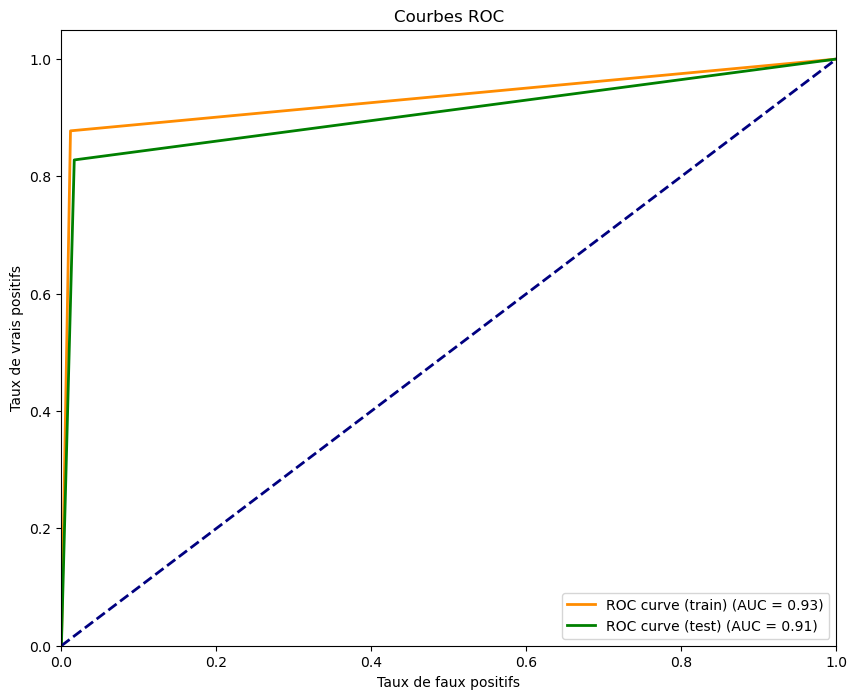

In [32]:
from sklearn.metrics import roc_curve, auc
# Obtenir les prédictions du modèle sur l'ensemble d'entraînement et de test
result=mod3
y_train_pred = result.predict(train_X)
y_test_pred = result.predict(test_X)

# Calculer les courbes ROC et les aires sous la courbe (AUC)
fpr_train, tpr_train, thresholds_train = roc_curve(train_y, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(test_y, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC')
plt.legend(loc="lower right")
plt.show()

In [33]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score

# Supposons que vos données sont déjà chargées dans train_X, train_y, test_X, test_y

# Normalisation
min_max_scaler = MinMaxScaler()
train_X_normalized = min_max_scaler.fit_transform(train_X)
test_X_normalized = min_max_scaler.transform(test_X)

# Standardisation
standard_scaler =  RobustScaler()
train_X_standardized = standard_scaler.fit_transform(train_X)
test_X_standardized = standard_scaler.transform(test_X)

# Entraîner un modèle XGBoost sans transformation
model = XGBClassifier()
model.fit(train_X, train_y)
y_pred = model.predict(test_X)
print(f"Accuracy sans transformation: {accuracy_score(test_y, y_pred)}")

# Entraîner un modèle XGBoost avec normalisation
model.fit(train_X_normalized, train_y)
y_pred_normalized = model.predict(test_X_normalized)
print(f"Accuracy avec normalisation: {accuracy_score(test_y, y_pred_normalized)}")

# Entraîner un modèle XGBoost avec standardisation
model.fit(train_X_standardized, train_y)
y_pred_standardized = model.predict(test_X_standardized)
print(f"Accuracy avec standardisation: {accuracy_score(test_y, y_pred_standardized)}")


Accuracy sans transformation: 0.9507540781779009
Accuracy avec normalisation: 0.9507540781779009
Accuracy avec standardisation: 0.9507540781779009


In [34]:
import optuna
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Supposons que train_X, train_y, test_X, test_y soient déjà définis
# train_X, train_y = ...
# test_X, test_y = ...

# Fonction objectif pour Optuna
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0)
    }
    
    model =  LGBMClassifier(**param)
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    
    f1 = metrics.f1_score(test_y, y_pred, average='weighted')
    
    return f1

# Créer une étude et optimiser
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Afficher les meilleurs hyperparamètres trouvés
print("Best hyperparameters: ", study.best_params)
print("Best F1 Score: ", study.best_value)

# Entraîner le modèle final avec les meilleurs hyperparamètres
best_params = study.best_params
mod2 =  LGBMClassifier(**best_params)
mod2.fit(train_X, train_y)
y_pred = mod2.predict(test_X)

# Afficher le rapport de classification
print(metrics.classification_report(test_y, y_pred))


[I 2024-07-18 09:40:47,436] A new study created in memory with name: no-name-30776063-b752-4731-a4f4-c74438b6f248


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.5706197372115427. Current value: lambda_l2=0.5706197372115427
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.5706197372115427. Current value: lambda_l2=0.5706197372115427
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-07-18 09:40:47,710] Trial 0 finished with value: 0.9404436110301649 and parameters: {'max_depth': 3, 'learning_rate': 0.07321207368458157, 'n_estimators': 81, 'subsample': 0.5192328091499214, 'colsample_bytree': 0.8200155602864678, 'lambda': 0.5706197372115427, 'alpha': 0.1707543098923148}. Best is trial 0 with value: 0.9404436110301649.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.5706197372115427. Current value: lambda_l2=0.5706197372115427
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7000042538074384. Current value: lambda_l2=0.7000042538074384
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7000042538074384. Current value: lambda_l2=0.7000042538074384
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score 

[I 2024-07-18 09:40:47,889] Trial 1 finished with value: 0.9252712877845161 and parameters: {'max_depth': 2, 'learning_rate': 0.045228136472832234, 'n_estimators': 69, 'subsample': 0.5113589851871148, 'colsample_bytree': 0.6107015350649583, 'lambda': 0.7000042538074384, 'alpha': 0.8815055221224922}. Best is trial 0 with value: 0.9404436110301649.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.3132832569791171. Current value: lambda_l2=0.3132832569791171
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.3132832569791171. Current value: lambda_l2=0.3132832569791171
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-07-18 09:40:48,142] Trial 2 finished with value: 0.9411235901285226 and parameters: {'max_depth': 1, 'learning_rate': 0.29629012783017167, 'n_estimators': 189, 'subsample': 0.5080458999782573, 'colsample_bytree': 0.9828050454603549, 'lambda': 0.3132832569791171, 'alpha': 0.194658012216827}. Best is trial 2 with value: 0.9411235901285226.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.5396382587426559. Current value: lambda_l2=0.5396382587426559
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.5396382587426559. Current value: lambda_l2=0.5396382587426559
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-07-18 09:40:48,644] Trial 3 finished with value: 0.9489356906806552 and parameters: {'max_depth': 5, 'learning_rate': 0.2712210535593751, 'n_estimators': 129, 'subsample': 0.6796291056409794, 'colsample_bytree': 0.6841643652101637, 'lambda': 0.5396382587426559, 'alpha': 0.3557067360026492}. Best is trial 3 with value: 0.9489356906806552.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.5396382587426559. Current value: lambda_l2=0.5396382587426559
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.20004658356829394. Current value: lambda_l2=0.20004658356829394
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.20004658356829394. Current value: lambda_l2=0.20004658356829394
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pa

[I 2024-07-18 09:40:49,009] Trial 4 finished with value: 0.9436792857020546 and parameters: {'max_depth': 3, 'learning_rate': 0.07327772400029982, 'n_estimators': 175, 'subsample': 0.5506488163241761, 'colsample_bytree': 0.8899361281480711, 'lambda': 0.20004658356829394, 'alpha': 0.10539866475650811}. Best is trial 3 with value: 0.9489356906806552.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8248375810267774. Current value: lambda_l2=0.8248375810267774
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8248375810267774. Current value: lambda_l2=0.8248375810267774
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-07-18 09:40:50,367] Trial 5 finished with value: 0.9497671652951468 and parameters: {'max_depth': 10, 'learning_rate': 0.13281469227003065, 'n_estimators': 188, 'subsample': 0.6827147824663368, 'colsample_bytree': 0.6283499405657849, 'lambda': 0.8248375810267774, 'alpha': 0.5424047593001723}. Best is trial 5 with value: 0.9497671652951468.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8248375810267774. Current value: lambda_l2=0.8248375810267774
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9308126288584936. Current value: lambda_l2=0.9308126288584936
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9308126288584936. Current value: lambda_l2=0.9308126288584936
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:40:51,360] Trial 6 finished with value: 0.9536918571328004 and parameters: {'max_depth': 6, 'learning_rate': 0.13023674988071499, 'n_estimators': 170, 'subsample': 0.5815507586239481, 'colsample_bytree': 0.8669874866481222, 'lambda': 0.9308126288584936, 'alpha': 0.6883484694554782}. Best is trial 6 with value: 0.9536918571328004.
[I 2024-07-18 09:40:51,517] Trial 7 finished with value: 0.9377989786492562 and parameters: {'max_depth': 1, 'learning_rate': 0.2976483797258961, 'n_estimators': 61, 'subsample': 0.8934123355609126, 'colsample_bytree': 0.5955966123400591, 'lambda': 0.43585794322169874, 'alpha': 0.7491157276486591}. Best is trial 6 with value: 0.9536918571328004.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.43585794322169874. Current value: lambda_l2=0.43585794322169874
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.43585794322169874. Current value: lambda_l2=0.43585794322169874
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-07-18 09:40:52,013] Trial 8 finished with value: 0.9506105691921446 and parameters: {'max_depth': 8, 'learning_rate': 0.15760803632771556, 'n_estimators': 65, 'subsample': 0.6507644477112748, 'colsample_bytree': 0.5513924135774737, 'lambda': 0.47497068453737434, 'alpha': 0.4646585797999399}. Best is trial 6 with value: 0.9536918571328004.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.47497068453737434. Current value: lambda_l2=0.47497068453737434
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.23900301734693008. Current value: lambda_l2=0.23900301734693008
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.23900301734693008. Current value: lambda_l2=0.23900301734693008
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] A

[I 2024-07-18 09:40:52,247] Trial 9 finished with value: 0.938709416058039 and parameters: {'max_depth': 1, 'learning_rate': 0.21378534578174047, 'n_estimators': 146, 'subsample': 0.9376404174718818, 'colsample_bytree': 0.57540731421692, 'lambda': 0.23900301734693008, 'alpha': 0.2330609076671408}. Best is trial 6 with value: 0.9536918571328004.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9724488757120839. Current value: lambda_l2=0.9724488757120839
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9724488757120839. Current value: lambda_l2=0.9724488757120839
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:40:53,110] Trial 10 finished with value: 0.9521469375976984 and parameters: {'max_depth': 6, 'learning_rate': 0.1567298919991044, 'n_estimators': 161, 'subsample': 0.8271856587403291, 'colsample_bytree': 0.7733546857816992, 'lambda': 0.9724488757120839, 'alpha': 0.6694368774693601}. Best is trial 6 with value: 0.9536918571328004.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9724488757120839. Current value: lambda_l2=0.9724488757120839
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9349425914884879. Current value: lambda_l2=0.9349425914884879
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9349425914884879. Current value: lambda_l2=0.9349425914884879
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score 

[I 2024-07-18 09:40:53,992] Trial 11 finished with value: 0.9524790722221661 and parameters: {'max_depth': 6, 'learning_rate': 0.13996948115437338, 'n_estimators': 156, 'subsample': 0.8529592305818227, 'colsample_bytree': 0.767971112412345, 'lambda': 0.9349425914884879, 'alpha': 0.6951787930857016}. Best is trial 6 with value: 0.9536918571328004.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9349425914884879. Current value: lambda_l2=0.9349425914884879
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9877261320546546. Current value: lambda_l2=0.9877261320546546
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9877261320546546. Current value: lambda_l2=0.9877261320546546
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive g

[I 2024-07-18 09:40:54,733] Trial 12 finished with value: 0.949896114383973 and parameters: {'max_depth': 6, 'learning_rate': 0.11456079311434095, 'n_estimators': 106, 'subsample': 0.7983608924744139, 'colsample_bytree': 0.8767302925871147, 'lambda': 0.9877261320546546, 'alpha': 0.8992653646394279}. Best is trial 6 with value: 0.9536918571328004.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:40:55,780] Trial 13 finished with value: 0.9505495495402726 and parameters: {'max_depth': 8, 'learning_rate': 0.20136044833184333, 'n_estimators': 149, 'subsample': 0.9870497608400927, 'colsample_bytree': 0.7459645951774657, 'lambda': 0.7948078434126031, 'alpha': 0.6840906870786233}. Best is trial 6 with value: 0.9536918571328004.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.062025936702355844. Current value: lambda_l2=0.062025936702355844
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.062025936702355844. Current value: lambda_l2=0.062025936702355844
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2024-07-18 09:40:56,495] Trial 14 finished with value: 0.9351995997522645 and parameters: {'max_depth': 5, 'learning_rate': 0.011754127144313967, 'n_estimators': 121, 'subsample': 0.610309561984814, 'colsample_bytree': 0.9652228473307429, 'lambda': 0.062025936702355844, 'alpha': 0.9802325691284518}. Best is trial 6 with value: 0.9536918571328004.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:40:57,546] Trial 15 finished with value: 0.9489336195543456 and parameters: {'max_depth': 8, 'learning_rate': 0.20041714963405943, 'n_estimators': 166, 'subsample': 0.7562778398582087, 'colsample_bytree': 0.8656725227228781, 'lambda': 0.8564478172942176, 'alpha': 0.5495449429250716}. Best is trial 6 with value: 0.9536918571328004.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6788536535001208. Current value: lambda_l2=0.6788536535001208
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6788536535001208. Current value: lambda_l2=0.6788536535001208
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-07-18 09:40:58,755] Trial 16 finished with value: 0.9537672043030228 and parameters: {'max_depth': 7, 'learning_rate': 0.1073815041722609, 'n_estimators': 197, 'subsample': 0.8707698310210843, 'colsample_bytree': 0.7115926967580863, 'lambda': 0.6788536535001208, 'alpha': 0.8042892710043807}. Best is trial 16 with value: 0.9537672043030228.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6758313804774618. Current value: lambda_l2=0.6758313804774618
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6758313804774618. Current value: lambda_l2=0.6758313804774618
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-07-18 09:41:00,075] Trial 17 finished with value: 0.9509358415521657 and parameters: {'max_depth': 10, 'learning_rate': 0.0935028725322195, 'n_estimators': 200, 'subsample': 0.7468294225029679, 'colsample_bytree': 0.7008873047358818, 'lambda': 0.6758313804774618, 'alpha': 0.8077913850003561}. Best is trial 16 with value: 0.9537672043030228.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6758313804774618. Current value: lambda_l2=0.6758313804774618
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6977784754367853. Current value: lambda_l2=0.6977784754367853
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6977784754367853. Current value: lambda_l2=0.6977784754367853
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromSco

[I 2024-07-18 09:41:01,122] Trial 18 finished with value: 0.9494755031558796 and parameters: {'max_depth': 7, 'learning_rate': 0.16823817815070125, 'n_estimators': 178, 'subsample': 0.588541479290489, 'colsample_bytree': 0.5145410041931422, 'lambda': 0.6977784754367853, 'alpha': 0.41452987543524383}. Best is trial 16 with value: 0.9537672043030228.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6246576993709196. Current value: lambda_l2=0.6246576993709196
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6246576993709196. Current value: lambda_l2=0.6246576993709196
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-07-18 09:41:01,582] Trial 19 finished with value: 0.9457133118882317 and parameters: {'max_depth': 4, 'learning_rate': 0.1065805498963829, 'n_estimators': 130, 'subsample': 0.7381292168883969, 'colsample_bytree': 0.9361572667568884, 'lambda': 0.6246576993709196, 'alpha': 0.597949013279363}. Best is trial 16 with value: 0.9537672043030228.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:41:02,830] Trial 20 finished with value: 0.94735570193394 and parameters: {'max_depth': 9, 'learning_rate': 0.2414437580306334, 'n_estimators': 199, 'subsample': 0.8968720152876326, 'colsample_bytree': 0.8202581578054657, 'lambda': 0.7697735888915083, 'alpha': 0.8113170108546506}. Best is trial 16 with value: 0.9537672043030228.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7697735888915083. Current value: lambda_l2=0.7697735888915083
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9059344630455188. Current value: lambda_l2=0.9059344630455188
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9059344630455188. Current value: lambda_l2=0.9059344630455188
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training 

[I 2024-07-18 09:41:03,848] Trial 21 finished with value: 0.9537672043030228 and parameters: {'max_depth': 7, 'learning_rate': 0.13247169727468083, 'n_estimators': 154, 'subsample': 0.8413907671287523, 'colsample_bytree': 0.7615644500950914, 'lambda': 0.9059344630455188, 'alpha': 0.6728948727698499}. Best is trial 16 with value: 0.9537672043030228.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8865892368917029. Current value: lambda_l2=0.8865892368917029
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8865892368917029. Current value: lambda_l2=0.8865892368917029
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-07-18 09:41:05,092] Trial 22 finished with value: 0.9538418176979641 and parameters: {'max_depth': 7, 'learning_rate': 0.18029946228128085, 'n_estimators': 176, 'subsample': 0.8788132968931138, 'colsample_bytree': 0.6922163666066601, 'lambda': 0.8865892368917029, 'alpha': 0.9933117110490968}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8865892368917029. Current value: lambda_l2=0.8865892368917029
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8654107489715768. Current value: lambda_l2=0.8654107489715768
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8654107489715768. Current value: lambda_l2=0.8654107489715768
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, nu

[I 2024-07-18 09:41:06,349] Trial 23 finished with value: 0.9487274200291793 and parameters: {'max_depth': 7, 'learning_rate': 0.18291096247584246, 'n_estimators': 185, 'subsample': 0.8827866119254931, 'colsample_bytree': 0.6755237856476981, 'lambda': 0.8654107489715768, 'alpha': 0.9894427735276116}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8654107489715768. Current value: lambda_l2=0.8654107489715768
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7523499585568465. Current value: lambda_l2=0.7523499585568465
[LightGBM] [Warning] 

[I 2024-07-18 09:41:07,295] Trial 24 finished with value: 0.9510545682702267 and parameters: {'max_depth': 7, 'learning_rate': 0.23170037948808028, 'n_estimators': 145, 'subsample': 0.9544237091099108, 'colsample_bytree': 0.7232360144932779, 'lambda': 0.7523499585568465, 'alpha': 0.8990974476759277}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7523499585568465. Current value: lambda_l2=0.7523499585568465
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8851983929536864. Current value: lambda_l2=0.8851983929536864
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8851983929536864. Current value: lambda_l2=0.8851983929536864
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-ch

[I 2024-07-18 09:41:08,498] Trial 25 finished with value: 0.9522246398436734 and parameters: {'max_depth': 9, 'learning_rate': 0.08400620549198082, 'n_estimators': 177, 'subsample': 0.8042601015258846, 'colsample_bytree': 0.6544135864184896, 'lambda': 0.8851983929536864, 'alpha': 0.8083659265398492}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6077531823092526. Current value: lambda_l2=0.6077531823092526
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6077531823092526. Current value: lambda_l2=0.6077531823092526
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-07-18 09:41:09,451] Trial 26 finished with value: 0.9521078001523261 and parameters: {'max_depth': 7, 'learning_rate': 0.058363286736907515, 'n_estimators': 157, 'subsample': 0.8559698643904583, 'colsample_bytree': 0.7324512491506247, 'lambda': 0.6077531823092526, 'alpha': 0.9263330759190851}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:41:10,308] Trial 27 finished with value: 0.953066071418379 and parameters: {'max_depth': 9, 'learning_rate': 0.10823538023368935, 'n_estimators': 110, 'subsample': 0.9201057583963587, 'colsample_bytree': 0.7877383251954746, 'lambda': 0.41938179001852005, 'alpha': 0.759239480420929}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7493710182016273. Current value: lambda_l2=0.7493710182016273
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7493710182016273. Current value: lambda_l2=0.7493710182016273
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-07-18 09:41:11,022] Trial 28 finished with value: 0.9507748020664589 and parameters: {'max_depth': 5, 'learning_rate': 0.1830891589933724, 'n_estimators': 139, 'subsample': 0.9809046931363979, 'colsample_bytree': 0.8200597382342888, 'lambda': 0.7493710182016273, 'alpha': 0.587087637207371}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:41:11,458] Trial 29 finished with value: 0.9402433557957489 and parameters: {'max_depth': 4, 'learning_rate': 0.03881132634936446, 'n_estimators': 90, 'subsample': 0.7897334421530853, 'colsample_bytree': 0.660356515468102, 'lambda': 0.9023556624781254, 'alpha': 0.009275875039772896}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:41:12,740] Trial 30 finished with value: 0.9513467808167728 and parameters: {'max_depth': 8, 'learning_rate': 0.1403218614656155, 'n_estimators': 193, 'subsample': 0.8480889193020648, 'colsample_bytree': 0.7110160005423449, 'lambda': 0.56415810073199, 'alpha': 0.8580901285991451}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9391989969903372. Current value: lambda_l2=0.9391989969903372
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9391989969903372. Current value: lambda_l2=0.9391989969903372
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:41:13,580] Trial 31 finished with value: 0.9508557164961776 and parameters: {'max_depth': 6, 'learning_rate': 0.12610005034223432, 'n_estimators': 169, 'subsample': 0.8749492282373144, 'colsample_bytree': 0.7965951754089542, 'lambda': 0.9391989969903372, 'alpha': 0.6250627823317687}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9391989969903372. Current value: lambda_l2=0.9391989969903372
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8520307795138561. Current value: lambda_l2=0.8520307795138561
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8520307795138561. Current value: lambda_l2=0.8520307795138561
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score 

[I 2024-07-18 09:41:14,535] Trial 32 finished with value: 0.950801901765772 and parameters: {'max_depth': 7, 'learning_rate': 0.1807436488979927, 'n_estimators': 171, 'subsample': 0.7147192712967188, 'colsample_bytree': 0.8421408542657144, 'lambda': 0.8520307795138561, 'alpha': 0.7394529557889356}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:41:15,138] Trial 33 finished with value: 0.9471426957778498 and parameters: {'max_depth': 4, 'learning_rate': 0.09801250773321449, 'n_estimators': 185, 'subsample': 0.8215786883114313, 'colsample_bytree': 0.9078596907175503, 'lambda': 0.9883192537872428, 'alpha': 0.9377456021265074}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6736441448812118. Current value: lambda_l2=0.6736441448812118
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6736441448812118. Current value: lambda_l2=0.6736441448812118
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-07-18 09:41:16,024] Trial 34 finished with value: 0.951188714275114 and parameters: {'max_depth': 6, 'learning_rate': 0.12707843328306567, 'n_estimators': 162, 'subsample': 0.7764042315789081, 'colsample_bytree': 0.6239349066692654, 'lambda': 0.6736441448812118, 'alpha': 0.8384908970048326}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6736441448812118. Current value: lambda_l2=0.6736441448812118
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9305339660733919. Current value: lambda_l2=0.9305339660733919
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9305339660733919. Current value: lambda_l2=0.9305339660733919
[LightGBM] [Info] N

[I 2024-07-18 09:41:17,169] Trial 35 finished with value: 0.9529627869350588 and parameters: {'max_depth': 7, 'learning_rate': 0.15104317181806395, 'n_estimators': 184, 'subsample': 0.9404460907760511, 'colsample_bytree': 0.7426967862413987, 'lambda': 0.9305339660733919, 'alpha': 0.6534710883108602}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9305339660733919. Current value: lambda_l2=0.9305339660733919
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8059051669181223. Current value: lambda_l2=0.8059051669181223
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.805905

[I 2024-07-18 09:41:17,783] Trial 36 finished with value: 0.9466767919921107 and parameters: {'max_depth': 5, 'learning_rate': 0.06853850442274616, 'n_estimators': 137, 'subsample': 0.5425666638989793, 'colsample_bytree': 0.6901872536893766, 'lambda': 0.8059051669181223, 'alpha': 0.47915236182792675}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8059051669181223. Current value: lambda_l2=0.8059051669181223
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7250964320962889. Current value: lambda_l2=0.7250964320962889
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7250964320962889. Current value: lambda_l2=0.7250964320962889
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score 

[I 2024-07-18 09:41:18,931] Trial 37 finished with value: 0.952301585639138 and parameters: {'max_depth': 8, 'learning_rate': 0.11707289806573462, 'n_estimators': 194, 'subsample': 0.917042369276643, 'colsample_bytree': 0.9240802419988644, 'lambda': 0.7250964320962889, 'alpha': 0.7324082720373487}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7250964320962889. Current value: lambda_l2=0.7250964320962889
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8180017211841639. Current value: lambda_l2=0.8180017211841639
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8180017211841639. Current value: lambda_l2=0.8180017211841639
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train se

[I 2024-07-18 09:41:19,473] Trial 38 finished with value: 0.9462263185671881 and parameters: {'max_depth': 3, 'learning_rate': 0.16813955671957048, 'n_estimators': 178, 'subsample': 0.6845825367439837, 'colsample_bytree': 0.6467118224365873, 'lambda': 0.8180017211841639, 'alpha': 0.32084655860461814}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:41:20,219] Trial 39 finished with value: 0.9476394391407555 and parameters: {'max_depth': 5, 'learning_rate': 0.0793740202093617, 'n_estimators': 152, 'subsample': 0.5010732348515626, 'colsample_bytree': 0.8094843917052668, 'lambda': 0.5126922767924605, 'alpha': 0.5494670371579515}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:41:20,603] Trial 40 finished with value: 0.9503911756641512 and parameters: {'max_depth': 6, 'learning_rate': 0.24268199523301076, 'n_estimators': 51, 'subsample': 0.6462021759125132, 'colsample_bytree': 0.8385238079007994, 'lambda': 0.6346600651147842, 'alpha': 0.7839077536712609}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6346600651147842. Current value: lambda_l2=0.6346600651147842
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.3836862068839647. Current value: lambda_l2=0.3836862068839647
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.3836862068839647. Current value: lambda_l2=0.3836862068839647
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, nu

[I 2024-07-18 09:41:21,440] Trial 41 finished with value: 0.9518929017747668 and parameters: {'max_depth': 9, 'learning_rate': 0.10583998267867002, 'n_estimators': 108, 'subsample': 0.9131260536858555, 'colsample_bytree': 0.7586328989569664, 'lambda': 0.3836862068839647, 'alpha': 0.7549029298929588}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.3836862068839647. Current value: lambda_l2=0.3836862068839647
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.38243065

[I 2024-07-18 09:41:22,335] Trial 42 finished with value: 0.9515214073702172 and parameters: {'max_depth': 10, 'learning_rate': 0.14195487801234394, 'n_estimators': 116, 'subsample': 0.9578363685182825, 'colsample_bytree': 0.7781535756448879, 'lambda': 0.38243065708035284, 'alpha': 0.8527787055732582}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.2707831538355744. Current value: lambda_l2=0.2707831538355744
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.2707831538355744. Current value: lambda_l2=0.2707831538355744
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-07-18 09:41:23,376] Trial 43 finished with value: 0.9514419144509297 and parameters: {'max_depth': 9, 'learning_rate': 0.09405944178297204, 'n_estimators': 96, 'subsample': 0.9178494308250346, 'colsample_bytree': 0.7879875195126661, 'lambda': 0.2707831538355744, 'alpha': 0.6927703641580304}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.2707831538355744. Current value: lambda_l2=0.2707831538355744
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.4506752125078642. Current value: lambda_l2=0.4506752125078642
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.4506752125078642. Current value: lambda_l2=0.4506752125078642
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train se

[I 2024-07-18 09:41:24,219] Trial 44 finished with value: 0.9515608626788896 and parameters: {'max_depth': 7, 'learning_rate': 0.12164349014891641, 'n_estimators': 77, 'subsample': 0.8366641231415318, 'colsample_bytree': 0.855326948873764, 'lambda': 0.4506752125078642, 'alpha': 0.6382191610741489}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:41:25,081] Trial 45 finished with value: 0.9507230215964753 and parameters: {'max_depth': 8, 'learning_rate': 0.15189623828239676, 'n_estimators': 110, 'subsample': 0.8704599012810355, 'colsample_bytree': 0.7307411882526352, 'lambda': 0.37442949492769256, 'alpha': 0.7722885609122259}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.37442949492769256. Current value: lambda_l2=0.37442949492769256
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.925208185302567. Current value: lambda_l2=0.925208185302567
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.925208185302567. Current value: lambda_l2=0.925208185302567
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1

[I 2024-07-18 09:41:25,729] Trial 46 finished with value: 0.9505224129541734 and parameters: {'max_depth': 6, 'learning_rate': 0.1683409437435216, 'n_estimators': 97, 'subsample': 0.901889313105024, 'colsample_bytree': 0.6770016750862599, 'lambda': 0.925208185302567, 'alpha': 0.952802041742438}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.925208185302567. Current value: lambda_l2=0.925208185302567
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.4996440863521646. Current value: lambda_l2=0.4996440863521646
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.4996440863521646. Current value: lambda_l2=0.4996440863521646
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[I 2024-07-18 09:41:26,921] Trial 47 finished with value: 0.9508958771427363 and parameters: {'max_depth': 8, 'learning_rate': 0.05001131305709189, 'n_estimators': 165, 'subsample': 0.8120594742604218, 'colsample_bytree': 0.7099540730643747, 'lambda': 0.4996440863521646, 'alpha': 0.7218083578480226}. Best is trial 22 with value: 0.9538418176979641.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:41:27,887] Trial 48 finished with value: 0.9541352378781774 and parameters: {'max_depth': 9, 'learning_rate': 0.13533132312540294, 'n_estimators': 127, 'subsample': 0.9377543389652121, 'colsample_bytree': 0.7616121738037216, 'lambda': 0.05761251743265222, 'alpha': 0.5056795222274696}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.05761251743265222. Current value: lambda_l2=0.05761251743265222
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.11782706144942248. Current value: lambda_l2=0.11782706144942248
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.11782706144942248. Current value: lambda_l2=0.11782706144942248
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with posi

[I 2024-07-18 09:41:28,811] Trial 49 finished with value: 0.950059029417367 and parameters: {'max_depth': 7, 'learning_rate': 0.20180054327972352, 'n_estimators': 129, 'subsample': 0.96773588694953, 'colsample_bytree': 0.756364986223939, 'lambda': 0.11782706144942248, 'alpha': 0.35652202106379016}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.11782706144942248. Current value: lambda_l2=0.11782706144942248
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.12327137203843877. Current value: lambda_l2=0.12327137203843877
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.12327137203843877. Current value: lambda_l2=0.12327137203843877
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: 

[I 2024-07-18 09:41:30,099] Trial 50 finished with value: 0.950270346915255 and parameters: {'max_depth': 10, 'learning_rate': 0.1342245275846247, 'n_estimators': 157, 'subsample': 0.939978859749429, 'colsample_bytree': 0.6035212561360599, 'lambda': 0.12327137203843877, 'alpha': 0.5127521315958238}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.12327137203843877. Current value: lambda_l2=0.12327137203843877
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.018872657870445966. Current value: lambda_l2=0.018872657870445966
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.018872657870445966. Current value: lambda_l2=0.018872657870445966
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training f

[I 2024-07-18 09:41:31,374] Trial 51 finished with value: 0.951600125331826 and parameters: {'max_depth': 9, 'learning_rate': 0.11145594544194638, 'n_estimators': 124, 'subsample': 0.9997656025932479, 'colsample_bytree': 0.7946469832120315, 'lambda': 0.018872657870445966, 'alpha': 0.6860119117653714}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.018872657870445966. Current value: lambda_l2=0.018872657870445966
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.14814538201663735. Current value: lambda_l2=0.14814538201663735
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.14814538201663735. Current value: lambda_l2=0.14814538201663735
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0020

[I 2024-07-18 09:41:32,454] Trial 52 finished with value: 0.951600125331826 and parameters: {'max_depth': 8, 'learning_rate': 0.14713728316309893, 'n_estimators': 116, 'subsample': 0.8600166118448442, 'colsample_bytree': 0.7693305704014567, 'lambda': 0.14814538201663735, 'alpha': 0.5873418310795501}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.14814538201663735. Current value: lambda_l2=0.14814538201663735
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.33234919456928713. Current value: lambda_l2=0.33234919456928713
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.33234919456928713. Current value: lambda_l2=0.33234919456928713
[LightGBM] [I

[I 2024-07-18 09:41:33,820] Trial 53 finished with value: 0.9486427075451399 and parameters: {'max_depth': 9, 'learning_rate': 0.16295185610028684, 'n_estimators': 173, 'subsample': 0.9381977597653836, 'colsample_bytree': 0.8814403640176263, 'lambda': 0.33234919456928713, 'alpha': 0.4104563801159852}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9996993116088582. Current value: lambda_l2=0.9996993116088582
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9996993116088582. Current value: lambda_l2=0.9996993116088582
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-07-18 09:41:35,129] Trial 54 finished with value: 0.9526701839771984 and parameters: {'max_depth': 10, 'learning_rate': 0.12985441231227296, 'n_estimators': 182, 'subsample': 0.8983261513498535, 'colsample_bytree': 0.9583560061892628, 'lambda': 0.9996993116088582, 'alpha': 0.8829552548170663}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9996993116088582. Current value: lambda_l2=0.9996993116088582
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8496252120896292. Current value: lambda_l2=0.8496252120896292
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8496252120896292. Current value: lambda_l2=0.8496252120896292
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2024-07-18 09:41:35,519] Trial 55 finished with value: 0.941753284351747 and parameters: {'max_depth': 2, 'learning_rate': 0.08675561064044902, 'n_estimators': 140, 'subsample': 0.5852543265912835, 'colsample_bytree': 0.7216694733821292, 'lambda': 0.8496252120896292, 'alpha': 0.4475195021253965}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8496252120896292. Current value: lambda_l2=0.8496252120896292
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7808752758155098. Current value: lambda_l2=0.7808752758155098
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7808752758155098. Current value: lambda_l2=0.7808752758155098
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:41:36,473] Trial 56 finished with value: 0.9506433667559295 and parameters: {'max_depth': 6, 'learning_rate': 0.09910226324741561, 'n_estimators': 192, 'subsample': 0.8386363513146815, 'colsample_bytree': 0.6890253974411749, 'lambda': 0.7808752758155098, 'alpha': 0.6157823959104435}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:41:37,361] Trial 57 finished with value: 0.9520684703934984 and parameters: {'max_depth': 8, 'learning_rate': 0.10879214884295534, 'n_estimators': 133, 'subsample': 0.8878392530442045, 'colsample_bytree': 0.7502543116701178, 'lambda': 0.9423331304595391, 'alpha': 0.19879106528727108}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9423331304595391. Current value: lambda_l2=0.9423331304595391
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.24701741633152022. Current value: lambda_l2=0.24701741633152022
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.24701741633152022. Current value: lambda_l2=0.24701741633152022
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pa

[I 2024-07-18 09:41:38,175] Trial 58 finished with value: 0.949896114383973 and parameters: {'max_depth': 7, 'learning_rate': 0.07033513260459912, 'n_estimators': 152, 'subsample': 0.7797897194264312, 'colsample_bytree': 0.8094472002624632, 'lambda': 0.24701741633152022, 'alpha': 0.509627720653121}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:41:38,901] Trial 59 finished with value: 0.9515608626788896 and parameters: {'max_depth': 9, 'learning_rate': 0.17719342532057977, 'n_estimators': 103, 'subsample': 0.9239009089869366, 'colsample_bytree': 0.8396204839772162, 'lambda': 0.8806412433701887, 'alpha': 0.8146667717197397}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8806412433701887. Current value: lambda_l2=0.8806412433701887
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7079083446643514. Current value: lambda_l2=0.7079083446643514
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7079083446643514. Current value: lambda_l2=0.7079083446643514
[LightGBM] [Info] N

[I 2024-07-18 09:41:39,744] Trial 60 finished with value: 0.9508153585083612 and parameters: {'max_depth': 6, 'learning_rate': 0.19192125532153084, 'n_estimators': 145, 'subsample': 0.8777152683308984, 'colsample_bytree': 0.5693606304257013, 'lambda': 0.7079083446643514, 'alpha': 0.7056959128080035}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7079083446643514. Current value: lambda_l2=0.7079083446643514
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9606447180961281. Current value: lambda_l2=0.9606447180961281
[LightGBM] [Warning] 

[I 2024-07-18 09:41:40,918] Trial 61 finished with value: 0.9509358415521657 and parameters: {'max_depth': 7, 'learning_rate': 0.15987889485307374, 'n_estimators': 188, 'subsample': 0.9471130769269368, 'colsample_bytree': 0.733167534266017, 'lambda': 0.9606447180961281, 'alpha': 0.6694355813138799}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9606447180961281. Current value: lambda_l2=0.9606447180961281
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9127133485978783. Current value: lambda_l2=0.9127133485978783
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9127133485978783. Current value: lambda_l2=0.9127133485978783
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2024-07-18 09:41:41,976] Trial 62 finished with value: 0.9509358415521657 and parameters: {'max_depth': 7, 'learning_rate': 0.1494497778786165, 'n_estimators': 181, 'subsample': 0.974827339045923, 'colsample_bytree': 0.7425030553745586, 'lambda': 0.9127133485978783, 'alpha': 0.6575506138333169}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9127133485978783. Current value: lambda_l2=0.9127133485978783
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.18768634490917863. Current value: lambda_l2=0.18768634490917863
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.18768634490917863. Current value: lambda_l2=0.18768634490917863
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positi

[I 2024-07-18 09:41:43,113] Trial 63 finished with value: 0.9499779707601749 and parameters: {'max_depth': 7, 'learning_rate': 0.13626140262910882, 'n_estimators': 197, 'subsample': 0.9318718832135401, 'colsample_bytree': 0.6974530002515079, 'lambda': 0.18768634490917863, 'alpha': 0.5812594172378565}. Best is trial 48 with value: 0.9541352378781774.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.18768634490917863. Current value: lambda_l2=0.18768634490917863
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8276682980380168. Current value: lambda_l2=0.8276682980380168
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8276682980380168. Current value: lambda_l2=0.8276682980380168
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-

[I 2024-07-18 09:41:44,045] Trial 64 finished with value: 0.955748628055803 and parameters: {'max_depth': 8, 'learning_rate': 0.11691709150222959, 'n_estimators': 168, 'subsample': 0.9093808119335305, 'colsample_bytree': 0.9883675903578313, 'lambda': 0.8276682980380168, 'alpha': 0.6478035612116751}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8276682980380168. Current value: lambda_l2=0.8276682980380168
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8309890704027809. Current value: lambda_l2=0.8309890704027809
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8309890704027809. Current value: lambda_l2=0.8309890704027809
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-ch

[I 2024-07-18 09:41:45,113] Trial 65 finished with value: 0.9532929447143406 and parameters: {'max_depth': 8, 'learning_rate': 0.11693243907767414, 'n_estimators': 169, 'subsample': 0.8539119642125458, 'colsample_bytree': 0.9640885164684736, 'lambda': 0.8309890704027809, 'alpha': 0.782392269511192}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8309890704027809. Current value: lambda_l2=0.8309890704027809
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8338347676631378. Current value: lambda_l2=0.8338347676631378
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8338347676631378. Current value: lambda_l2=0.8338347676631378
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score 

[I 2024-07-18 09:41:46,184] Trial 66 finished with value: 0.9549801736841573 and parameters: {'max_depth': 8, 'learning_rate': 0.11951257602665595, 'n_estimators': 168, 'subsample': 0.8625212868188536, 'colsample_bytree': 0.9921888790741353, 'lambda': 0.8338347676631378, 'alpha': 0.5492146463126131}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.882059877452226. Current value: lambda_l2=0.882059877452226
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.882059877452226. Current value: lambda_l2=0.882059877452226
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-07-18 09:41:47,232] Trial 67 finished with value: 0.9547226978910631 and parameters: {'max_depth': 8, 'learning_rate': 0.1307898780832545, 'n_estimators': 163, 'subsample': 0.8696561152837381, 'colsample_bytree': 0.986036881564287, 'lambda': 0.882059877452226, 'alpha': 0.5337788226487987}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7446054787251439. Current value: lambda_l2=0.7446054787251439
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7446054787251439. Current value: lambda_l2=0.7446054787251439
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-07-18 09:41:48,237] Trial 68 finished with value: 0.9527724678251795 and parameters: {'max_depth': 8, 'learning_rate': 0.1255844280524525, 'n_estimators': 162, 'subsample': 0.8321013451155503, 'colsample_bytree': 0.9857279960106275, 'lambda': 0.7446054787251439, 'alpha': 0.5338650559354927}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8934272216246741. Current value: lambda_l2=0.8934272216246741
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8934272216246741. Current value: lambda_l2=0.8934272216246741
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-07-18 09:41:49,269] Trial 69 finished with value: 0.9531803400787817 and parameters: {'max_depth': 8, 'learning_rate': 0.14115177376996652, 'n_estimators': 175, 'subsample': 0.864483483751645, 'colsample_bytree': 0.9942732059684719, 'lambda': 0.8934272216246741, 'alpha': 0.43629859509427954}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7841976572898216. Current value: lambda_l2=0.7841976572898216
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7841976572898216. Current value: lambda_l2=0.7841976572898216
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-07-18 09:41:50,313] Trial 70 finished with value: 0.9553472124029103 and parameters: {'max_depth': 8, 'learning_rate': 0.10430877349247648, 'n_estimators': 165, 'subsample': 0.9038182483436008, 'colsample_bytree': 0.8997132411110836, 'lambda': 0.7841976572898216, 'alpha': 0.5572353885533904}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7878522960038018. Current value: lambda_l2=0.7878522960038018
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7878522960038018. Current value: lambda_l2=0.7878522960038018
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-07-18 09:41:51,305] Trial 71 finished with value: 0.9518929017747668 and parameters: {'max_depth': 8, 'learning_rate': 0.10118006150677533, 'n_estimators': 166, 'subsample': 0.900397471763707, 'colsample_bytree': 0.9407892115411927, 'lambda': 0.7878522960038018, 'alpha': 0.48228553645614}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7878522960038018. Current value: lambda_l2=0.7878522960038018
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8352534568611262. Current value: lambda_l2=0.8352534568611262
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.835253

[I 2024-07-18 09:41:52,304] Trial 72 finished with value: 0.9554903465391213 and parameters: {'max_depth': 9, 'learning_rate': 0.08811534700854438, 'n_estimators': 153, 'subsample': 0.8849772253524175, 'colsample_bytree': 0.9808540772213444, 'lambda': 0.8352534568611262, 'alpha': 0.5619251033788324}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8352534568611262. Current value: lambda_l2=0.8352534568611262
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8274077544451012. Current value: lambda_l2=0.8274077544451012
[LightGBM] [Warning] 

[I 2024-07-18 09:41:53,245] Trial 73 finished with value: 0.9553832586161864 and parameters: {'max_depth': 9, 'learning_rate': 0.08274515856477849, 'n_estimators': 159, 'subsample': 0.8870731443580473, 'colsample_bytree': 0.9719885908862599, 'lambda': 0.8274077544451012, 'alpha': 0.570166369161475}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8274077544451012. Current value: lambda_l2=0.8274077544451012
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8277638852441077. Current value: lambda_l2=0.8277638852441077
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8277638852441077. Current value: lambda_l2=0.8277638852441077
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002224 secon

[I 2024-07-18 09:41:54,212] Trial 74 finished with value: 0.9553832586161864 and parameters: {'max_depth': 9, 'learning_rate': 0.08794138156136065, 'n_estimators': 160, 'subsample': 0.9100258711186441, 'colsample_bytree': 0.9993338611381392, 'lambda': 0.8277638852441077, 'alpha': 0.5633095597100414}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8277638852441077. Current value: lambda_l2=0.8277638852441077
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.837988194924993. Current value: lambda_l2=0.837988194924993
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.83798819

[I 2024-07-18 09:41:55,126] Trial 75 finished with value: 0.9538046022110646 and parameters: {'max_depth': 9, 'learning_rate': 0.08792108857818998, 'n_estimators': 160, 'subsample': 0.9050735971028989, 'colsample_bytree': 0.9738741855056621, 'lambda': 0.837988194924993, 'alpha': 0.5644935643760544}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.837988194924993. Current value: lambda_l2=0.837988194924993
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8141895118317907. Current value: lambda_l2=0.8141895118317907
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.81418951

[I 2024-07-18 09:41:56,081] Trial 76 finished with value: 0.9556773886079132 and parameters: {'max_depth': 10, 'learning_rate': 0.06453488824798713, 'n_estimators': 148, 'subsample': 0.8852572196341446, 'colsample_bytree': 0.9989887653034429, 'lambda': 0.8141895118317907, 'alpha': 0.5395821049643224}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8141895118317907. Current value: lambda_l2=0.8141895118317907
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8125909094723014. Current value: lambda_l2=0.8125909094723014
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8125909094723014. Current value: lambda_l2=0.8125909094723014
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score 

[I 2024-07-18 09:41:57,040] Trial 77 finished with value: 0.9537672043030228 and parameters: {'max_depth': 10, 'learning_rate': 0.041580650329915106, 'n_estimators': 150, 'subsample': 0.8788470454607183, 'colsample_bytree': 0.9952706620900553, 'lambda': 0.8125909094723014, 'alpha': 0.5454641041844803}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8125909094723014. Current value: lambda_l2=0.8125909094723014
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7638330244283383. Current value: lambda_l2=0.7638330244283383
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7638330244283383. Current value: lambda_l2=0.7638330244283383
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-ch

[I 2024-07-18 09:41:58,167] Trial 78 finished with value: 0.9498134512866925 and parameters: {'max_depth': 10, 'learning_rate': 0.019137457908313782, 'n_estimators': 147, 'subsample': 0.8210131720865375, 'colsample_bytree': 0.9498022435304155, 'lambda': 0.7638330244283383, 'alpha': 0.6141089494440976}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7638330244283383. Current value: lambda_l2=0.7638330244283383
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7191645373041332. Current value: lambda_l2=0.7191645373041332
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7191645373041332. Current value: lambda_l2=0.7191645373041332
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score 

[I 2024-07-18 09:41:59,208] Trial 79 finished with value: 0.9534736688673683 and parameters: {'max_depth': 10, 'learning_rate': 0.06519132878172829, 'n_estimators': 158, 'subsample': 0.8889237345127972, 'colsample_bytree': 0.9127142178306236, 'lambda': 0.7191645373041332, 'alpha': 0.5262969251809282}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7191645373041332. Current value: lambda_l2=0.7191645373041332
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8673620706230225. Current value: lambda_l2=0.8673620706230225
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8673620706230225. Current value: lambda_l2=0.8673620706230225
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0

[I 2024-07-18 09:42:00,173] Trial 80 finished with value: 0.9535486030080494 and parameters: {'max_depth': 9, 'learning_rate': 0.07831842797503343, 'n_estimators': 142, 'subsample': 0.9092183626327511, 'colsample_bytree': 0.9778674270644707, 'lambda': 0.8673620706230225, 'alpha': 0.4033532703574232}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8673620706230225. Current value: lambda_l2=0.8673620706230225
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8028399762672531. Current value: lambda_l2=0.8028399762672531
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8028399762672531. Current value: lambda_l2=0.8028399762672531
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score 

[I 2024-07-18 09:42:01,242] Trial 81 finished with value: 0.9550167393218597 and parameters: {'max_depth': 9, 'learning_rate': 0.057895780504490596, 'n_estimators': 164, 'subsample': 0.9604439955040999, 'colsample_bytree': 0.9837783562798617, 'lambda': 0.8028399762672531, 'alpha': 0.48995746534797596}. Best is trial 64 with value: 0.955748628055803.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8028399762672531. Current value: lambda_l2=0.8028399762672531
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7994528013447483. Current value: lambda_l2=0.7994528013447483
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7994528013447483. Current value: lambda_l2=0.7994528013447483
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training 

[I 2024-07-18 09:42:02,363] Trial 82 finished with value: 0.9565610316926819 and parameters: {'max_depth': 9, 'learning_rate': 0.06084689831550504, 'n_estimators': 166, 'subsample': 0.9601264192720627, 'colsample_bytree': 0.9998969822676537, 'lambda': 0.7994528013447483, 'alpha': 0.5640956153216728}. Best is trial 82 with value: 0.9565610316926819.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7994528013447483. Current value: lambda_l2=0.7994528013447483
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8062520887051663. Current value: lambda_l2=0.8062520887051663
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8062520887051663. Current value: lambda_l2=0.8062520887051663
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-ch

[I 2024-07-18 09:42:03,409] Trial 83 finished with value: 0.9537296229531617 and parameters: {'max_depth': 9, 'learning_rate': 0.05692898502059891, 'n_estimators': 169, 'subsample': 0.9260889960505255, 'colsample_bytree': 0.9322734668904078, 'lambda': 0.8062520887051663, 'alpha': 0.5662929581041479}. Best is trial 82 with value: 0.9565610316926819.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8062520887051663. Current value: lambda_l2=0.8062520887051663
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6581987906206335. Current value: lambda_l2=0.6581987906206335
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6581987906206335. Current value: lambda_l2=0.6581987906206335
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-ch

[I 2024-07-18 09:42:04,494] Trial 84 finished with value: 0.9514419144509297 and parameters: {'max_depth': 10, 'learning_rate': 0.028618470338638485, 'n_estimators': 157, 'subsample': 0.9591398126220474, 'colsample_bytree': 0.9510665927986057, 'lambda': 0.6581987906206335, 'alpha': 0.4707854744558727}. Best is trial 82 with value: 0.9565610316926819.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.6581987906206335. Current value: lambda_l2=0.6581987906206335
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7853921989748278. Current value: lambda_l2=0.7853921989748278
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7853921989748278. Current value: lambda_l2=0.7853921989748278
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training 

[I 2024-07-18 09:42:05,433] Trial 85 finished with value: 0.9539859256365484 and parameters: {'max_depth': 9, 'learning_rate': 0.060968021543736706, 'n_estimators': 167, 'subsample': 0.9703896911883743, 'colsample_bytree': 0.9693432580350595, 'lambda': 0.7853921989748278, 'alpha': 0.6017025106703929}. Best is trial 82 with value: 0.9565610316926819.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7853921989748278. Current value: lambda_l2=0.7853921989748278
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8384022098339006. Current value: lambda_l2=0.8384022098339006
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8384022098339006. Current value: lambda_l2=0.8384022098339006
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2024-07-18 09:42:06,162] Trial 86 finished with value: 0.9560072689851906 and parameters: {'max_depth': 9, 'learning_rate': 0.07700461032677793, 'n_estimators': 153, 'subsample': 0.9529549651727889, 'colsample_bytree': 0.9936442647427369, 'lambda': 0.8384022098339006, 'alpha': 0.635431836030204}. Best is trial 82 with value: 0.9565610316926819.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8384022098339006. Current value: lambda_l2=0.8384022098339006
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7320586241436898. Current value: lambda_l2=0.7320586241436898
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7320586241436898. Current value: lambda_l2=0.7320586241436898
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0

[I 2024-07-18 09:42:07,276] Trial 87 finished with value: 0.9546859683125096 and parameters: {'max_depth': 10, 'learning_rate': 0.05015305832392025, 'n_estimators': 155, 'subsample': 0.9623962249037035, 'colsample_bytree': 0.9775379490838452, 'lambda': 0.7320586241436898, 'alpha': 0.6255044507276769}. Best is trial 82 with value: 0.9565610316926819.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:42:08,061] Trial 88 finished with value: 0.9522246398436734 and parameters: {'max_depth': 9, 'learning_rate': 0.07474236527706235, 'n_estimators': 150, 'subsample': 0.9938362543483565, 'colsample_bytree': 0.9042063780589478, 'lambda': 0.7677136115059764, 'alpha': 0.640100713893646}. Best is trial 82 with value: 0.9565610316926819.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:42:08,807] Trial 89 finished with value: 0.9550531264756305 and parameters: {'max_depth': 9, 'learning_rate': 0.0822182357578952, 'n_estimators': 154, 'subsample': 0.9826594170556426, 'colsample_bytree': 0.9988119450299602, 'lambda': 0.6916231883017896, 'alpha': 0.5678810024358123}. Best is trial 82 with value: 0.9565610316926819.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.698339140627181. Current value: lambda_l2=0.698339140627181
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.698339140627181. Current value: lambda_l2=0.698339140627181
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-07-18 09:42:09,541] Trial 90 finished with value: 0.9543919718124413 and parameters: {'max_depth': 10, 'learning_rate': 0.0909218364752779, 'n_estimators': 143, 'subsample': 0.9875327827837485, 'colsample_bytree': 0.959151687014798, 'lambda': 0.698339140627181, 'alpha': 0.5698567721887747}. Best is trial 82 with value: 0.9565610316926819.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8085164617315909. Current value: lambda_l2=0.8085164617315909
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8085164617315909. Current value: lambda_l2=0.8085164617315909
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-07-18 09:42:10,409] Trial 91 finished with value: 0.956891041850116 and parameters: {'max_depth': 9, 'learning_rate': 0.08235036416196281, 'n_estimators': 160, 'subsample': 0.9501176584951226, 'colsample_bytree': 0.9968208894721478, 'lambda': 0.8085164617315909, 'alpha': 0.49994382925728564}. Best is trial 91 with value: 0.956891041850116.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8085164617315909. Current value: lambda_l2=0.8085164617315909
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8509140285324589. Current value: lambda_l2=0.8509140285324589
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8509140285324589. Current value: lambda_l2=0.8509140285324589
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002432 secon

[I 2024-07-18 09:42:11,076] Trial 92 finished with value: 0.9553832586161864 and parameters: {'max_depth': 9, 'learning_rate': 0.08212370385422581, 'n_estimators': 136, 'subsample': 0.9485613375283212, 'colsample_bytree': 0.9482075289867841, 'lambda': 0.8509140285324589, 'alpha': 0.5990913443936876}. Best is trial 91 with value: 0.956891041850116.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8509140285324589. Current value: lambda_l2=0.8509140285324589
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8640173605284674. Current value: lambda_l2=0.8640173605284674
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8640173605284674. Current value: lambda_l2=0.8640173605284674
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, nu

[I 2024-07-18 09:42:11,701] Trial 93 finished with value: 0.9525942992573685 and parameters: {'max_depth': 9, 'learning_rate': 0.07339844554359373, 'n_estimators': 135, 'subsample': 0.9481541113707767, 'colsample_bytree': 0.9437108008238893, 'lambda': 0.8640173605284674, 'alpha': 0.5871862370014616}. Best is trial 91 with value: 0.956891041850116.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-18 09:42:12,672] Trial 94 finished with value: 0.9537672043030228 and parameters: {'max_depth': 9, 'learning_rate': 0.09247422174010686, 'n_estimators': 160, 'subsample': 0.9262374325507393, 'colsample_bytree': 0.9201367647835429, 'lambda': 0.8465754201376282, 'alpha': 0.45633813991268113}. Best is trial 91 with value: 0.956891041850116.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8175414110564702. Current value: lambda_l2=0.8175414110564702
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8175414110564702. Current value: lambda_l2=0.8175414110564702
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-07-18 09:42:13,702] Trial 95 finished with value: 0.9550531264756305 and parameters: {'max_depth': 10, 'learning_rate': 0.06460847651457466, 'n_estimators': 149, 'subsample': 0.9493630945081591, 'colsample_bytree': 0.9725993043429996, 'lambda': 0.8175414110564702, 'alpha': 0.6056713763443405}. Best is trial 91 with value: 0.956891041850116.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8175414110564702. Current value: lambda_l2=0.8175414110564702
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7458395035995491. Current value: lambda_l2=0.7458395035995491
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7458395035995491. Current value: lambda_l2=0.7458395035995491
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0

[I 2024-07-18 09:42:14,764] Trial 96 finished with value: 0.9550893361385595 and parameters: {'max_depth': 9, 'learning_rate': 0.0794250627204301, 'n_estimators': 173, 'subsample': 0.9144365619752974, 'colsample_bytree': 0.9988602727608088, 'lambda': 0.7458395035995491, 'alpha': 0.6391470965928948}. Best is trial 91 with value: 0.956891041850116.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7458395035995491. Current value: lambda_l2=0.7458395035995491
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9640816298018109. Current value: lambda_l2=0.9640816298018109
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9640816298018109. Current value: lambda_l2=0.9640816298018109
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score 

[I 2024-07-18 09:42:15,719] Trial 97 finished with value: 0.9535857963796276 and parameters: {'max_depth': 9, 'learning_rate': 0.10129488489629723, 'n_estimators': 153, 'subsample': 0.887947956701387, 'colsample_bytree': 0.9533516284059186, 'lambda': 0.9640816298018109, 'alpha': 0.5144381866517793}. Best is trial 91 with value: 0.956891041850116.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9069780103133703. Current value: lambda_l2=0.9069780103133703
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9069780103133703. Current value: lambda_l2=0.9069780103133703
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156312 -> initscore=-1.685930
[LightGBM] [Info] Start training from score -1.685930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-07-18 09:42:16,740] Trial 98 finished with value: 0.9539859256365484 and parameters: {'max_depth': 10, 'learning_rate': 0.05228092472427891, 'n_estimators': 147, 'subsample': 0.9278101194407327, 'colsample_bytree': 0.9291385923040387, 'lambda': 0.9069780103133703, 'alpha': 0.7169288710550644}. Best is trial 91 with value: 0.956891041850116.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9069780103133703. Current value: lambda_l2=0.9069780103133703
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8671585652941367. Current value: lambda_l2=0.8671585652941367
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8671585652941367. Current value: lambda_l2=0.8671585652941367
[LightGBM] [Info] Number of positive: 1185, number of negative: 6396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002162 secon

[I 2024-07-18 09:42:17,741] Trial 99 finished with value: 0.9553832586161864 and parameters: {'max_depth': 9, 'learning_rate': 0.08628655390288906, 'n_estimators': 160, 'subsample': 0.9765880637926224, 'colsample_bytree': 0.9640765814186864, 'lambda': 0.8671585652941367, 'alpha': 0.43296103796858004}. Best is trial 91 with value: 0.956891041850116.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8671585652941367. Current value: lambda_l2=0.8671585652941367
Best hyperparameters:  

In [35]:
train_X

,montant_sollicite,duree_pret_souhaitee,taux_interet,nbr_mois_cotisation,nbr_credits_octroyes,ssecteur_activite_0,ssecteur_activite_1,ssecteur_activite_2,ssecteur_activite_3,ssecteur_activite_4,...,ssecteur_activite_37,ssecteur_activite_38,ssecteur_activite_39,ssecteur_activite_40,ssecteur_activite_41,ssecteur_activite_42,ssecteur_activite_43,ssecteur_activite_44,rapport_rembourse,rapport_rembour
12597,430000.0,12,18.0,12.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.140000
400,2000000.0,12,24.0,11.0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.473684
2187,150000.0,12,0.0,11.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.000000
3299,300000.0,12,19.0,5.0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.020408
11821,400000.0,12,18.0,12.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4153,200000.0,12,19.0,12.0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,-0.090909
11241,400000.0,11,18.0,11.0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.8,-0.129944
1040,1500000.0,12,24.0,11.0,10,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1.0,-0.034483
7574,2000000.0,12,19.0,12.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.000000


In [36]:
from xgboost import XGBClassifier
from sklearn import metrics

# Meilleurs hyperparamètres trouvés par Optuna
# Entraîner le modèle final avec les meilleurs hyperparamètres
mod1 = XGBClassifier(**best_params)
mod1.fit(train_X, train_y)
y_pred = mod1.predict(test_X)

# Afficher le rapport de classification
print(metrics.classification_report(test_y, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2714
           1       0.89      0.83      0.86       535

    accuracy                           0.95      3249
   macro avg       0.93      0.90      0.92      3249
weighted avg       0.95      0.95      0.95      3249



In [37]:
from sklearn.model_selection import  GridSearchCV
import time
# Définition des paramètres à optimiser
param_grid = {
    # max_depth est la profondeur maximale de chaque arbre. Une valeur plus élevée rendra le modèle plus complexe et pourrait entraîner un surapprentissage.
    'max_depth': [3, 4, 5,7,8],
    
    # learning_rate (ou taux d'apprentissage) est le pas d'ajustement effectué à chaque étape de l'optimisation. Une valeur plus faible rendra l'apprentissage plus lent.
    'learning_rate': [0.01, 0.1, 0.2],
    
    # n_estimators est le nombre d'arbres à construire.
    'n_estimators': [100, 200, 300,500,1000],
    
    
}

# Création de l'objet GridSearch

model = XGBClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=2)
# Enregistrement du temps actuel
start_time = time.time()

# Entraînement du modèle avec GridSearch
grid_search.fit(train_X, train_y)

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Fitting 5 folds for each of 75 candidates, totalling 375 fits


In [38]:
# Affichage des meilleurs paramètres
print("Best parameters found: ", grid_search.best_params_)

# Affichage du temps d'exécution
print("Temps d'exécution: %.2f secondes" % execution_time)

# Utilisation du meilleur modèle trouvé pour la prédiction
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(train_X)
y_test_pred = best_model.predict(test_X)
from sklearn.metrics import classification_report
# Classification Report
print("\nTrain Classification Report:")
print(classification_report(train_y, y_train_pred))
print("\nTest Classification Report:")
print(classification_report(test_y, y_test_pred))

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Temps d'exécution: 249.99 secondes

Train Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6396
           1       0.89      0.83      0.86      1185

    accuracy                           0.96      7581
   macro avg       0.93      0.90      0.92      7581
weighted avg       0.96      0.96      0.96      7581


Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2714
           1       0.88      0.81      0.84       535

    accuracy                           0.95      3249
   macro avg       0.92      0.89      0.91      3249
weighted avg       0.95      0.95      0.95      3249

